In [1]:
import os

os.chdir('/home/invites/routhier/sequence_design/')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import itertools
from Bio import SeqIO, motifs
import h5py

In [3]:
from keras.models import load_model
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

Using TensorFlow backend.


In [4]:
from MyModuleLibrary.mykeras.losses import mae_cor, correlate
from MyModuleLibrary.array_modifier import rolling_window

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True 
sess = tf.Session(config=config)
K.tensorflow_backend.set_session(sess) 

### Plotting the energy dload_modelalong with the MCMC process

In [17]:
energies_167 = np.zeros((1, 200))
energies_197 = np.zeros((1, 200))
energies_237 = np.zeros((1, 200))

for dirname in os.listdir('./Results_nucleosome/'):
    if re.match('visu_167_directory_\d+$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_167 = np.append(energies_167, energy[None, :], axis=0)
    
    if re.match('visu_197_directory_\d+$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_197 = np.append(energies_197, energy[None, :], axis=0)
    
    if re.match('visu_237_directory_\d+$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_237 = np.append(energies_237, energy[None, :], axis=0)

energies_167 = energies_167[1:]
energies_197 = energies_197[1:]
energies_237 = energies_237[1:]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

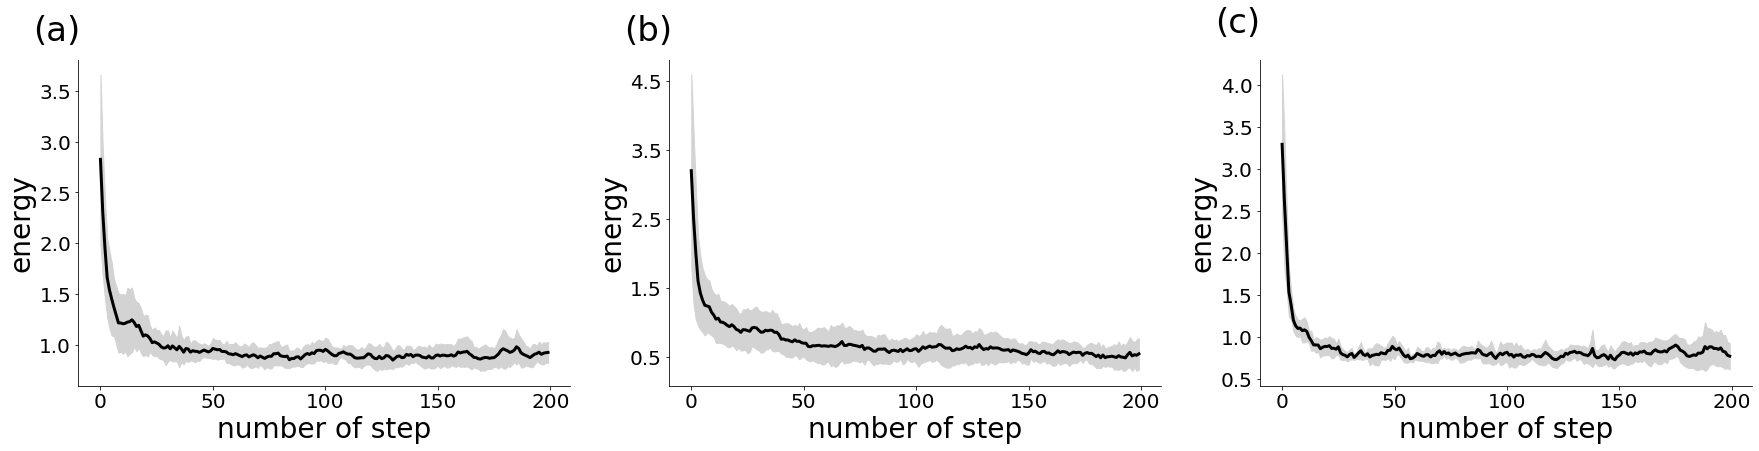

In [111]:
fig = plt.figure(figsize=(30, 6))
fontsize = 20

ax = fig.add_subplot(131)
ax.plot(np.mean(energies_167, axis=0), color='k', linewidth=3)
ax.fill_between(np.arange(200),
                np.mean(energies_167, axis=0) - np.std(energies_167, axis=0),
                np.mean(energies_167, axis=0) + np.std(energies_167, axis=0),
                color='lightgrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 250, 50))
ax.set_xticklabels(np.arange(0, 250, 50), fontsize=fontsize)
ax.set_yticks(np.arange(1, 4, 0.5))
ax.set_yticklabels(np.arange(1, 4, 0.5), fontsize=fontsize)
ax.set_xlabel('number of step', fontsize=fontsize + 8)
ax.set_ylabel('energy', fontsize=fontsize + 8)
ax.text(x=-30, y=4, s='(a)', fontsize=fontsize + 14)

ax1 = fig.add_subplot(132)
ax1.plot(np.mean(energies_197, axis=0), color='k', linewidth=3)
ax1.fill_between(np.arange(200),
                np.mean(energies_197, axis=0) - np.std(energies_197, axis=0),
                np.mean(energies_197, axis=0) + np.std(energies_197, axis=0),
                color='lightgrey')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(0, 250, 50))
ax1.set_xticklabels(np.arange(0, 250, 50), fontsize=fontsize)
ax1.set_yticks(np.arange(0.5, 5.5, 1))
ax1.set_yticklabels(np.arange(0.5, 5.5, 1), fontsize=fontsize)
ax1.set_xlabel('number of step', fontsize=fontsize + 8)
ax1.set_ylabel('energy', fontsize=fontsize + 8)
ax1.text(x=-30,
         y=np.mean(energies_197, axis=0)[0] + np.std(energies_197, axis=0)[0] + 0.5,
         s='(b)', fontsize=fontsize + 14)


ax2 = fig.add_subplot(133)
ax2.plot(np.mean(energies_237, axis=0), color='k', linewidth=3)
ax2.fill_between(np.arange(200),
                np.mean(energies_237, axis=0) - np.std(energies_237, axis=0),
                np.mean(energies_237, axis=0) + np.std(energies_237, axis=0),
                color='lightgrey')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks(np.arange(0, 250, 50))
ax2.set_xticklabels(np.arange(0, 250, 50), fontsize=fontsize)
ax2.set_yticks(np.arange(0.5, 4.5, 0.5))
ax2.set_yticklabels(np.arange(0.5, 4.5, 0.5), fontsize=fontsize)
ax2.set_xlabel('number of step', fontsize=fontsize + 8)
ax2.set_ylabel('energy', fontsize=fontsize + 8)
ax2.text(x=-30,
         y=np.mean(energies_237, axis=0)[0] + np.std(energies_237, axis=0)[0] + 0.5,
         s='(c)', fontsize=fontsize + 14)

fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/decroissance_energie.eps', format='eps', bbox_inchesstr='tight')

### Predicting the density of the best sequence in class

In [7]:
energies_167 = np.zeros((1, 200))
energies_197 = np.zeros((1, 200))
energies_237 = np.zeros((1, 200))

for dirname in os.listdir('./Results_nucleosome/'):
    if re.match('visu_167_directory_\d$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_167 = np.append(energies_167, energy[None, :], axis=0)
    
    if re.match('visu_197_directory_\d$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_197 = np.append(energies_197, energy[None, :], axis=0)
    
    if re.match('visu_237_directory_[012345678]$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_237 = np.append(energies_237, energy[None, :], axis=0)

energies_167 = energies_167[1:]
energies_197 = energies_197[1:]
energies_237 = energies_237[1:]

In [6]:
model = load_model('./Results_nucleosome/weights_with_rev_compl_rep2.hdf5', custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})
model.input_shape

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


(None, 2001, 4, 1)

In [10]:
def process_input(nucleotid, repeat=1, dummy=3):
    window = 2001
    seq_length = len(nucleotid)

    HALF_WX = window // 2
    MARGIN = 2 * HALF_WX
    repeat_number = MARGIN // seq_length + repeat + 2
    start = (HALF_WX // seq_length + 1) * seq_length - HALF_WX
    stop = start + repeat * seq_length + 2 * HALF_WX

    new_sequence = nucleotid

    for _ in range(repeat_number - 1):
        new_sequence = np.append(new_sequence, nucleotid)
    new_sequence = new_sequence[start : stop]

    res = (np.arange(4) == new_sequence[..., None] - 1).astype(int)
    res = res.reshape(res.shape[0], 4)

    x_slide = rolling_window(res, window=(window, 4))
    
    if dummy == 3:
        x_seq = x_slide.reshape(x_slide.shape[0], window, 4, 1)
    elif dummy == 2:
        x_seq = x_slide.reshape(x_slide.shape[0], window, 1, 4)
    return x_seq

In [59]:
from sklearn.neighbors import KernelDensity

def get_kde(array, length, multiplier=100):
    if len(np.shape(array)) == 2:
        array = array[:, 0]
    
    fake_samples = list()

    for i, value in enumerate(array):
        value = int(value * multiplier)
        for _ in range(value):
            fake_samples.append(i)
            
    for i, value in enumerate(array):
        value = int(value * multiplier)
        for _ in range(value):
            fake_samples.append(i + len(array))

    fake_samples = np.array(fake_samples)
    
    kde = KernelDensity(bandwidth=4, kernel='gaussian',).fit(fake_samples[:, None])
    log_dens = kde.score_samples(np.linspace(1, length * 2, length * 2)[:, np.newaxis])
    return np.concatenate([np.exp(log_dens)[length : length + 100],
                          np.exp(log_dens)[100 : length]]) * 2 * get_normalizer(length)

def get_normalizer(length):
    shift = 0.3
    amp = 0.3
    len601 = 147

    x_gauss = np.arange(1, len601)

    y_target_ = shift + amp * np.exp(-((x_gauss - ((len601 -1 ) / 2.)) ** 2 / (2. * len601 * len601 / 16.)))
    y_target_ = np.append(y_target_, np.repeat(y_target_[-1], (int(length) - (len601 - 1))))
    return np.sum(y_target_)

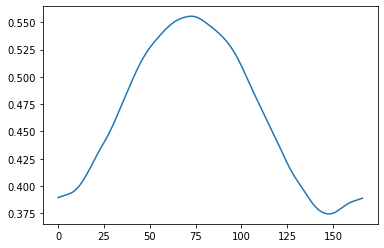

In [60]:
best_197 = np.array(h5py.File('/users/invites/routhier/Documents/Projet_nucleosomes/Alignment/to_send_collaborators/167.hdf5')['data'])
plt.plot(get_kde(model.predict(process_input(best_197)), 167))

In [28]:
predictions_167 = np.zeros((167, 1))
predictions_197 = np.zeros((197, 1))
predictions_237 = np.zeros((237, 1))

for i, arg in enumerate(np.argmin(energies_167, axis=1)):
    seq = np.load('./Results_nucleosome/visu_167_directory_' + str(i + 1) + '/designed_sequence_' + str(arg) + '.npy')
    local_input = process_input(seq)
    predictions_167 = np.append(predictions_167, model.predict(local_input), axis=1)
    
for i, arg in enumerate(np.argmin(energies_197, axis=1)):
    seq = np.load('./Results_nucleosome/visu_197_directory_' + str(i + 1) + '/designed_sequence_' + str(arg) + '.npy')
    local_input = process_input(seq)
    predictions_197 = np.append(predictions_197, model.predict(local_input), axis=1)

predictions_197 = np.append(predictions_197, model.predict(process_input(best_197)), axis=1)

for i, arg in enumerate(np.argmin(energies_237, axis=1)):
    seq = np.load('./Results_nucleosome/visu_237_directory_' + str(i + 1) + '/designed_sequence_' + str(arg) + '.npy')
    local_input = process_input(seq)
    predictions_237 = np.append(predictions_237, model.predict(local_input), axis=1)
    
predictions_167 = predictions_167[:, 1:]
predictions_197 = predictions_197[:, 1:]
predictions_237 = predictions_237[:, 1:]

Text(-70, 0.55, '(c)')

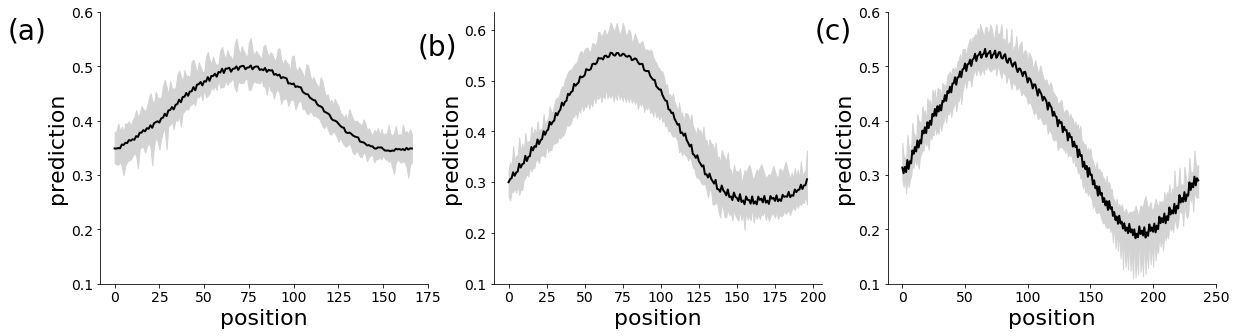

In [29]:
fontsize=14

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
start = 0
stop = 167
ax.fill_between(np.arange(start, stop),
                np.min(predictions_167, axis=1),
                np.max(predictions_167, axis=1),
                color='lightgrey')

ax.plot(np.mean(predictions_167, axis=1),
        color='k', 
        linewidth=2)

ax.set_ylim([0.2, 0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 200, 25))
ax.set_xticklabels(np.arange(0, 200, 25), fontsize=fontsize)
ax.set_yticks(np.arange(0.1, 0.7, 0.1))
ax.set_yticklabels(np.round(np.arange(0.1, 0.7, 0.1), 2), fontsize=fontsize)
ax.set_xlabel('position', fontsize=fontsize + 8)
ax.set_ylabel('prediction', fontsize=fontsize + 8)
ax.text(x=-60, y=0.55, s='(a)', fontsize=fontsize + 14)

ax1 = fig.add_subplot(1, 3, 2)
start = 0
stop = 197
ax1.fill_between(np.arange(start, stop),
                np.min(predictions_197, axis=1),
                np.max(predictions_197, axis=1),
                color='lightgrey')

ax1.plot(np.mean(predictions_197, axis=1),
        color='k', 
        linewidth=2)

#ax1.set_ylim([0.2, 0.6])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(0, 225, 25))
ax1.set_xticklabels(np.arange(0, 225, 25), fontsize=fontsize)
ax1.set_yticks(np.arange(0.1, 0.7, 0.1))
ax1.set_yticklabels(np.round(np.arange(0.1, 0.7, 0.1), 2), fontsize=fontsize)
ax1.set_xlabel('position', fontsize=fontsize + 8)
ax1.set_ylabel('prediction', fontsize=fontsize + 8)
ax1.text(x=-60, y=0.55, s='(b)', fontsize=fontsize + 14)

ax2 = fig.add_subplot(1, 3, 3)
start = 0
stop = 237
ax2.fill_between(np.arange(start, stop),
                np.min(predictions_237, axis=1),
                np.max(predictions_237, axis=1),
                color='lightgrey')

ax2.plot(np.mean(predictions_237, axis=1),
        color='k', 
        linewidth=2)

ax2.set_ylim([0.2, 0.6])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks(np.arange(0, 300, 50))
ax2.set_xticklabels(np.arange(0, 300, 50), fontsize=fontsize)
ax2.set_yticks(np.arange(0.1, 0.7, 0.1))
ax2.set_yticklabels(np.round(np.arange(0.1, 0.7, 0.1), 2), fontsize=fontsize)
ax2.set_xlabel('position', fontsize=fontsize + 8)
ax2.set_ylabel('prediction', fontsize=fontsize + 8)
ax2.text(x=-70, y=0.55, s='(c)', fontsize=fontsize + 14)

#fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/exemple_predictions.eps', format='eps', bbox_inchesstr='tight')

### Predicting the mean RNA seq density

In [74]:
model = load_model('/users/invites/routhier/Documents/Projet_RNA_seq/Results_RNA_seq/weight_CNN_RNA_seq_2001_12_8_4_SRR7131299.hdf5',
                   custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})
model.input_shape

(None, 2001, 4, 1)

In [81]:
predictions_167 = np.zeros((167, 1))
predictions_197 = np.zeros((197, 1))
predictions_237 = np.zeros((237, 1))

for dirname in os.listdir('./Results_nucleosome/'):
    if re.match('visu_167_directory_\d+$', dirname):
        seq = np.load('./Results_nucleosome/' + dirname + '/designed_sequence_19.npy')
        local_input = process_input(seq, dummy=3)
        predictions_167 = np.append(predictions_167, model.predict(local_input), axis=1)
        
for dirname in os.listdir('./Results_nucleosome/'):
    if re.match('visu_197_directory_\d+$', dirname):
        try:
            seq = np.load('./Results_nucleosome/' + dirname + '/designed_sequence_19.npy')
            local_input = process_input(seq, dummy=3)
            predictions_197 = np.append(predictions_197, model.predict(local_input), axis=1)
        except FileNotFoundError:
            pass
        
for dirname in os.listdir('./Results_nucleosome/'):
    if re.match('visu_237_directory_\d+$', dirname):
        try:
            seq = np.load('./Results_nucleosome/' + dirname + '/designed_sequence_19.npy')
            local_input = process_input(seq, dummy=3)
            predictions_237 = np.append(predictions_237, model.predict(local_input), axis=1)
        except FileNotFoundError:
            pass

predictions_167 = predictions_167[:, 1:]
predictions_197 = predictions_197[:, 1:]
predictions_237 = predictions_237[:, 1:]

In [89]:
f = h5py.File('/users/invites/routhier/Documents/Projet_nucleosomes/Alignment/to_send_collaborators/197.hdf5')
nucleotid = np.array(f['data'])[:, 0]
f.close()

local_input = process_input(nucleotid, dummy=3)
prediction_on_197 = model.predict(local_input)

f = h5py.File('/users/invites/routhier/Documents/Projet_nucleosomes/Alignment/to_send_collaborators/167.hdf5')
nucleotid = np.array(f['data'])[:, 0]
f.close()

local_input = process_input(nucleotid, dummy=3)
prediction_on_167 = model.predict(local_input)

f = h5py.File('/users/invites/routhier/Documents/Projet_nucleosomes/Alignment/to_send_collaborators/237.hdf5')
nucleotid = np.array(f['data'])[:, 0]
f.close()

local_input = process_input(nucleotid, dummy=3)
prediction_on_237 = model.predict(local_input)

f = h5py.File('/users/invites/routhier/Documents/Projet_nucleosomes/Alignment/to_send_collaborators/197_2.hdf5')
nucleotid = np.array(f['data'])[:, 0]
f.close()

local_input = process_input(nucleotid, dummy=3)
prediction_on_197_2 = model.predict(local_input)

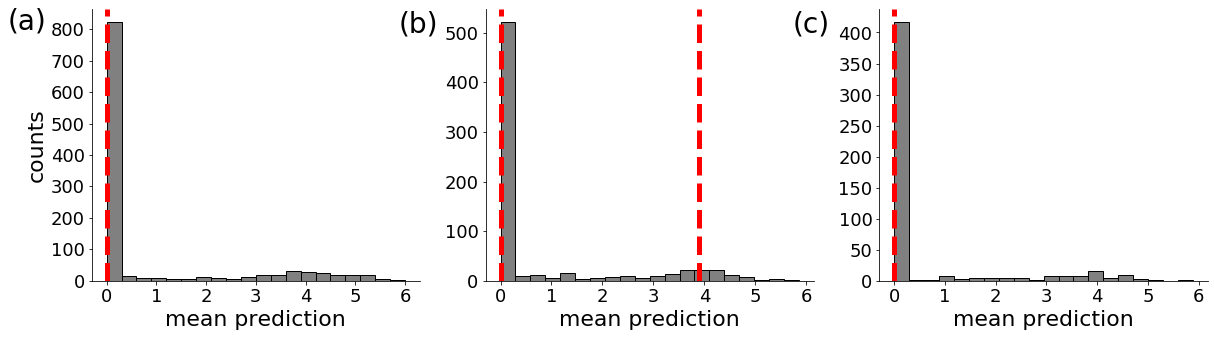

In [91]:
fontsize=14

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)

ax.hist(np.mean(predictions_167, axis=0), color='grey', edgecolor='k', bins=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('mean prediction', fontsize=fontsize + 8)
ax.set_ylabel('counts', fontsize=fontsize + 8)
plt.setp(ax.get_xticklabels(), fontsize=fontsize + 4)
plt.setp(ax.get_yticklabels(), fontsize=fontsize + 4)

ax.text(x=-2, y=800, s='(a)', fontsize=fontsize + 14)
ax.axvline(np.mean(prediction_on_167), linestyle='--', color='r', linewidth=5)

ax1 = fig.add_subplot(1, 3, 2)

ax1.hist(np.mean(predictions_197, axis=0), color='grey', edgecolor='k', bins=20)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_xlabel('mean prediction', fontsize=fontsize + 8)
plt.setp(ax1.get_xticklabels(), fontsize=fontsize + 4)
plt.setp(ax1.get_yticklabels(), fontsize=fontsize + 4)
ax1.text(x=-2, y=500, s='(b)', fontsize=fontsize + 14)

ax1.axvline(np.mean(prediction_on_197), linestyle='--', color='r', linewidth=5)
ax1.axvline(np.mean(prediction_on_197_2), linestyle='--', color='r', linewidth=5)

ax2 = fig.add_subplot(1, 3, 3)

ax2.hist(np.mean(predictions_237, axis=0), color='grey', edgecolor='k', bins=20)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.set_xlabel('mean prediction', fontsize=fontsize + 8)
plt.setp(ax2.get_xticklabels(), fontsize=fontsize + 4)
plt.setp(ax2.get_yticklabels(), fontsize=fontsize + 4)
ax2.text(x=-2, y=400, s='(c)', fontsize=fontsize + 14)
ax2.axvline(np.mean(prediction_on_237), linestyle='--', color='r', linewidth=5)

fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/distribution_transcription.eps', format='eps', bbox_inchesstr='tight')
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/distribution_transcription.png', format='png', bbox_inchesstr='tight')

### Prediciting the density and energy for a more difficult gaussian

In [107]:
energies_167 = np.zeros((1, 200))
energies_197 = np.zeros((1, 200))
energies_237 = np.zeros((1, 200))

for dirname in os.listdir('./Results_nucleosome/'):
    if re.match('visu_167_directory_\d_gauss_0.8_0.1$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_167 = np.append(energies_167, energy[None, :], axis=0)
    
    if re.match('visu_197_directory_[01234567]_gauss_0.8_0.1$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_197 = np.append(energies_197, energy[None, :], axis=0)
    
    if re.match('visu_237_directory_[01234]_gauss_0.8_0.1$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_237 = np.append(energies_237, energy[None, :], axis=0)

energies_167 = energies_167[1:]
energies_197 = energies_197[1:]
energies_237 = energies_237[1:]

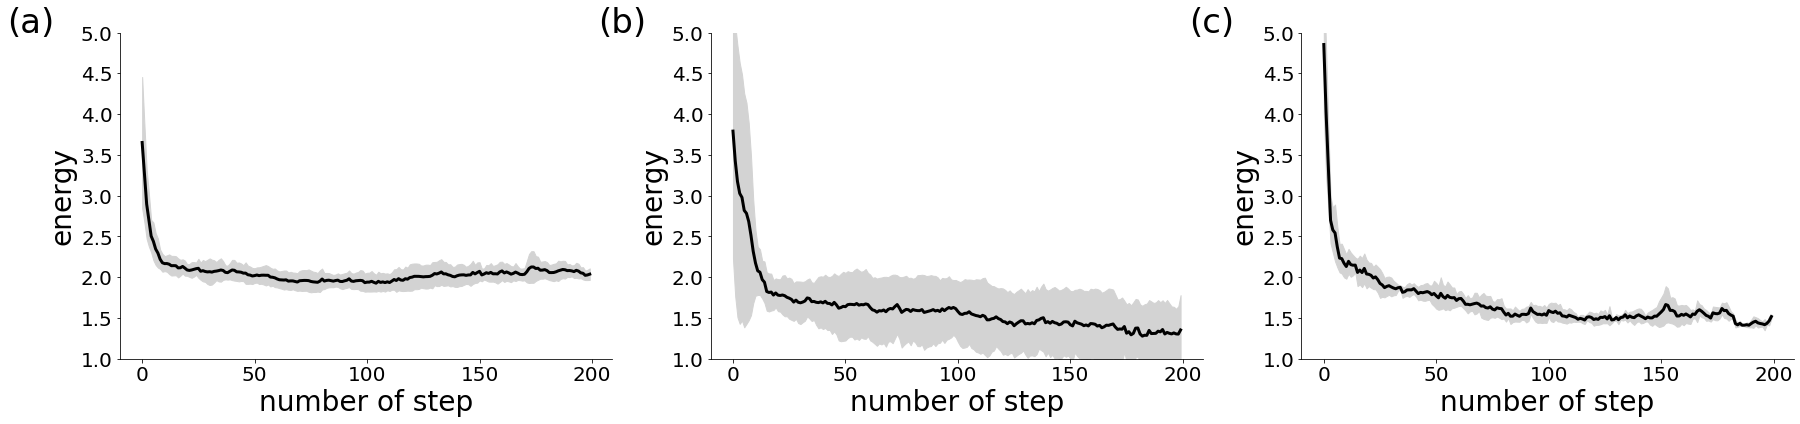

In [113]:
fig = plt.figure(figsize=(30, 6))
fontsize = 20

ax = fig.add_subplot(131)
ax.plot(np.mean(energies_167, axis=0), color='k', linewidth=3)
ax.fill_between(np.arange(200),
                np.mean(energies_167, axis=0) - np.std(energies_167, axis=0),
                np.mean(energies_167, axis=0) + np.std(energies_167, axis=0),
                color='lightgrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 250, 50))
ax.set_xticklabels(np.arange(0, 250, 50), fontsize=fontsize)
ax.set_ylim([1, 5])
ax.set_yticks(np.arange(1, 5.5, 0.5))
ax.set_yticklabels(np.arange(1, 5.5, 0.5), fontsize=fontsize)
ax.set_xlabel('number of step', fontsize=fontsize + 8)
ax.set_ylabel('energy', fontsize=fontsize + 8)
ax.text(x=-60,
        y=5, s='(a)', fontsize=fontsize + 14)

ax1 = fig.add_subplot(132)
ax1.plot(np.mean(energies_197, axis=0), color='k', linewidth=3)
ax1.fill_between(np.arange(200),
                np.mean(energies_197, axis=0) - np.std(energies_197, axis=0),
                np.mean(energies_197, axis=0) + np.std(energies_197, axis=0),
                color='lightgrey')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(0, 250, 50))
ax1.set_xticklabels(np.arange(0, 250, 50), fontsize=fontsize)
ax1.set_ylim([1, 5])
ax1.set_yticks(np.arange(1, 5.5, 0.5))
ax1.set_yticklabels(np.arange(1, 5.5, 0.5), fontsize=fontsize)
ax1.set_xlabel('number of step', fontsize=fontsize + 8)
ax1.set_ylabel('energy', fontsize=fontsize + 8)
ax1.text(x=-60,
         y=5,
         s='(b)', fontsize=fontsize + 14)


ax2 = fig.add_subplot(133)
ax2.plot(np.mean(energies_237, axis=0), color='k', linewidth=3)
ax2.fill_between(np.arange(200),
                np.mean(energies_237, axis=0) - np.std(energies_237, axis=0),
                np.mean(energies_237, axis=0) + np.std(energies_237, axis=0),
                color='lightgrey')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks(np.arange(0, 250, 50))
ax2.set_xticklabels(np.arange(0, 250, 50), fontsize=fontsize)
ax2.set_ylim([1, 5])
ax2.set_yticks(np.arange(1, 5.5, 0.5))
ax2.set_yticklabels(np.arange(1, 5.5, 0.5), fontsize=fontsize)
ax2.set_xlabel('number of step', fontsize=fontsize + 8)
ax2.set_ylabel('energy', fontsize=fontsize + 8)
ax2.text(x=-60,
         y=5,
         s='(c)', fontsize=fontsize + 14)

fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/decroissance_energie_gauss_0.8_0.1.eps', format='eps', bbox_inchesstr='tight')

In [114]:
energies_167 = np.zeros((1, 200))
energies_197 = np.zeros((1, 200))
energies_237 = np.zeros((1, 200))

for dirname in os.listdir('./Results_nucleosome/'):
    if re.match('visu_167_directory_\d_gauss_0.8_0.1$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_167 = np.append(energies_167, energy[None, :], axis=0)
    
    if re.match('visu_197_directory_[01234567]_gauss_0.8_0.1$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_197 = np.append(energies_197, energy[None, :], axis=0)
    
    if re.match('visu_237_directory_[01234]_gauss_0.8_0.1$', dirname):
        energy = pd.read_csv('./Results_nucleosome/' + dirname + '/energy.txt', names=['indexes', 'energy']).energy.values
        energies_237 = np.append(energies_237, energy[None, :], axis=0)

energies_167 = energies_167[1:]
energies_197 = energies_197[1:]
energies_237 = energies_237[1:]

In [115]:
predictions_167 = np.zeros((167, 1))
predictions_197 = np.zeros((197, 1))
predictions_237 = np.zeros((237, 1))

for i, arg in enumerate(np.argmin(energies_167, axis=1)):
    seq = np.load('./Results_nucleosome/visu_167_directory_' + str(i + 1) + '_gauss_0.8_0.1/designed_sequence_' + str(arg) + '.npy')
    local_input = process_input(seq)
    predictions_167 = np.append(predictions_167, model.predict(local_input), axis=1)
    
for i, arg in enumerate(np.argmin(energies_197, axis=1)):
    seq = np.load('./Results_nucleosome/visu_197_directory_' + str(i + 1) + '_gauss_0.8_0.1/designed_sequence_' + str(arg) + '.npy')
    local_input = process_input(seq)
    predictions_197 = np.append(predictions_197, model.predict(local_input), axis=1)
    
for i, arg in enumerate(np.argmin(energies_237, axis=1)):
    seq = np.load('./Results_nucleosome/visu_237_directory_' + str(i + 1) + '_gauss_0.8_0.1/designed_sequence_' + str(arg) + '.npy')
    local_input = process_input(seq)
    predictions_237 = np.append(predictions_237, model.predict(local_input), axis=1)
    
predictions_167 = predictions_167[:, 1:]
predictions_197 = predictions_197[:, 1:]
predictions_237 = predictions_237[:, 1:]

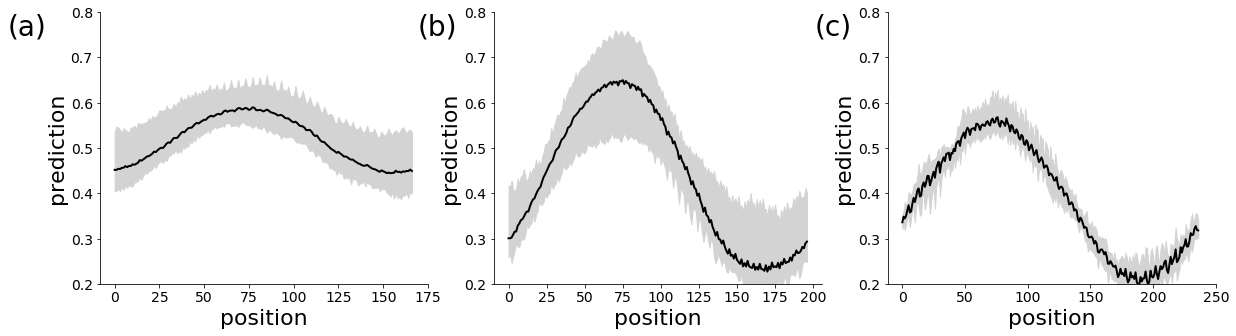

In [118]:
fontsize=14

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
start = 0
stop = 167
ax.fill_between(np.arange(start, stop),
                np.min(predictions_167, axis=1),
                np.max(predictions_167, axis=1),
                color='lightgrey')

ax.plot(np.mean(predictions_167, axis=1),
        color='k', 
        linewidth=2)

ax.set_ylim([0.2, 0.8])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 200, 25))
ax.set_xticklabels(np.arange(0, 200, 25), fontsize=fontsize)
ax.set_yticks(np.arange(0.2, 0.9, 0.1))
ax.set_yticklabels(np.round(np.arange(0.2, 0.9, 0.1), 2), fontsize=fontsize)
ax.set_xlabel('position', fontsize=fontsize + 8)
ax.set_ylabel('prediction', fontsize=fontsize + 8)
ax.text(x=-60, y=0.75, s='(a)', fontsize=fontsize + 14)

ax1 = fig.add_subplot(1, 3, 2)
start = 0
stop = 197
ax1.fill_between(np.arange(start, stop),
                np.min(predictions_197, axis=1),
                np.max(predictions_197, axis=1),
                color='lightgrey')

ax1.plot(np.mean(predictions_197, axis=1),
        color='k', 
        linewidth=2)

ax1.set_ylim([0.2, 0.8])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(0, 225, 25))
ax1.set_xticklabels(np.arange(0, 225, 25), fontsize=fontsize)
ax1.set_yticks(np.arange(0.2, 0.9, 0.1))
ax1.set_yticklabels(np.round(np.arange(0.2, 0.9, 0.1), 2), fontsize=fontsize)
ax1.set_xlabel('position', fontsize=fontsize + 8)
ax1.set_ylabel('prediction', fontsize=fontsize + 8)
ax1.text(x=-60, y=0.75, s='(b)', fontsize=fontsize + 14)

ax2 = fig.add_subplot(1, 3, 3)
start = 0
stop = 237
ax2.fill_between(np.arange(start, stop),
                np.min(predictions_237, axis=1),
                np.max(predictions_237, axis=1),
                color='lightgrey')

ax2.plot(np.mean(predictions_237, axis=1),
        color='k', 
        linewidth=2)

ax2.set_ylim([0.2, 0.8])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks(np.arange(0, 300, 50))
ax2.set_xticklabels(np.arange(0, 300, 50), fontsize=fontsize)
ax2.set_yticks(np.arange(0.2, 0.9, 0.1))
ax2.set_yticklabels(np.round(np.arange(0.2, 0.9, 0.1), 2), fontsize=fontsize)
ax2.set_xlabel('position', fontsize=fontsize + 8)
ax2.set_ylabel('prediction', fontsize=fontsize + 8)
ax2.text(x=-70, y=0.75, s='(c)', fontsize=fontsize + 14)

fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/exemple_predictions_gauss_0.8_0.1.eps', format='eps', bbox_inchesstr='tight')

### Analysing the mutations positions and typology

In [21]:
def get_mutation_sequence(length, repeat):
    position = list()
    mutation = list()
    
    energy = pd.read_csv('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/energy.txt', names=['indexes', 'energy']).energy.values
    for i in range(19):
        seq_step_i = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(i) + '.npy')
        seq_step_i_plus = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(i + 1) + '.npy')
        position.append(np.where(seq_step_i != seq_step_i_plus)[0][0])
        mutation.append(seq_step_i_plus[position[-1]])
        
    return np.array(position), np.array(mutation), - energy[1:] + energy[:-1]

def get_energy_gain_per_pos(length, repeat):
    position, _, energy = get_mutation_sequence(length, repeat)
    energy_gain_per_pos = np.zeros((length,))

    for i in range(length):
        energy_gain_per_pos[i] = np.sum(energy[np.where(position == i)[0]])
    return energy_gain_per_pos

In [22]:
def get_mutation_pos(length, repeat, step):
    seq_step_i = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(step - 1) + '.npy')
    seq_step_i_plus = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(step) + '.npy')
    position = np.where(seq_step_i != seq_step_i_plus)[0][0]
    mutation = seq_step_i_plus[position]
    nucleotid = seq_step_i[position]

    return position * 3 + min(relu(mutation - nucleotid), relu(4 - nucleotid + mutation)) - 1

def relu(number):
    if number < 0:
        return 10
    else:
        return number

##### Evolution of the total energie

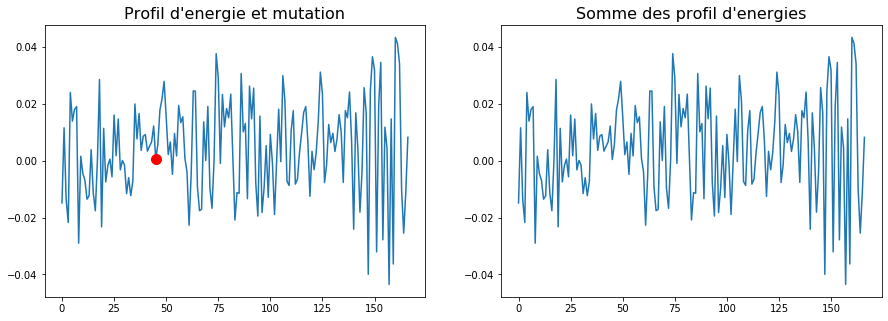

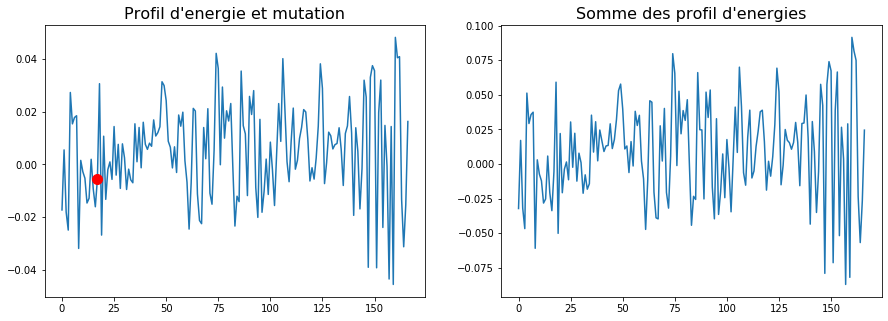

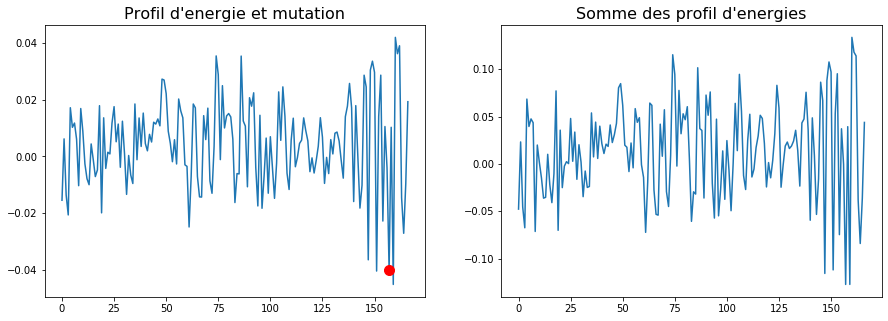

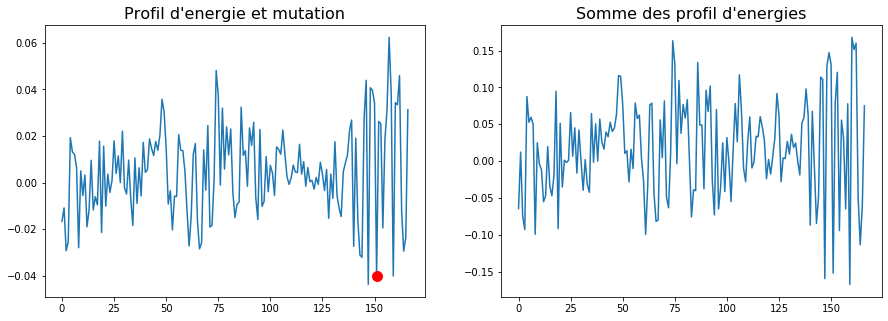

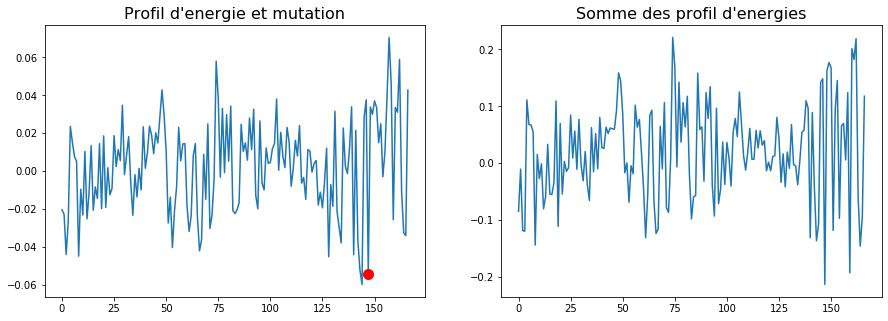

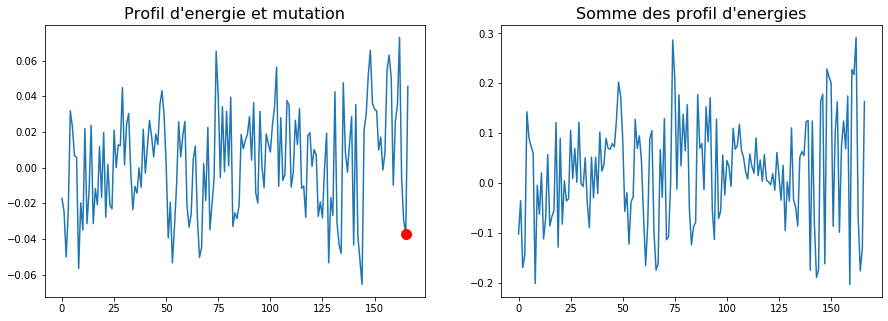

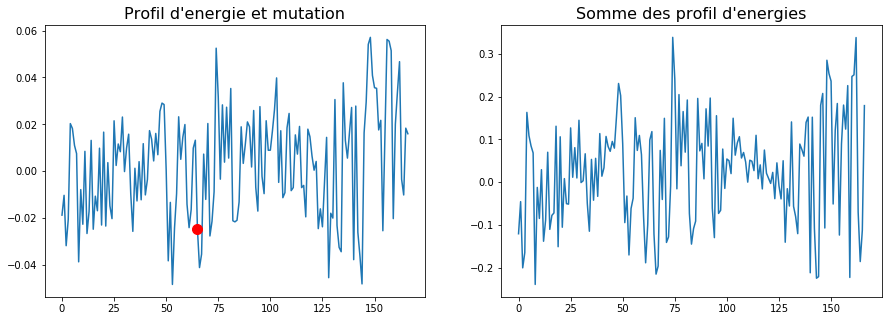

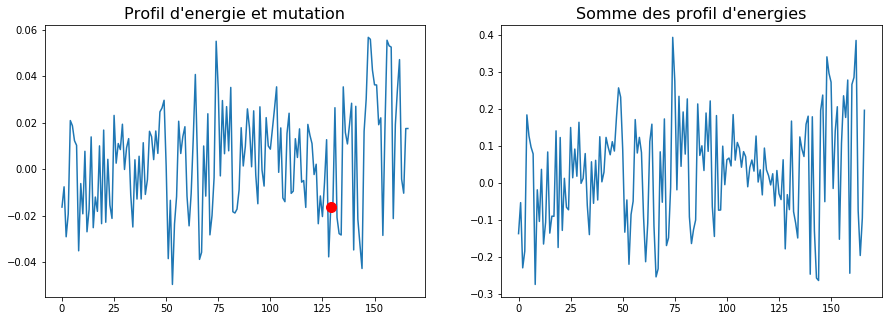

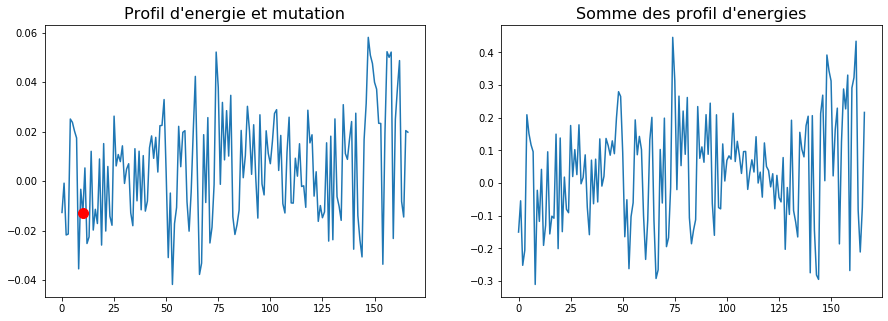

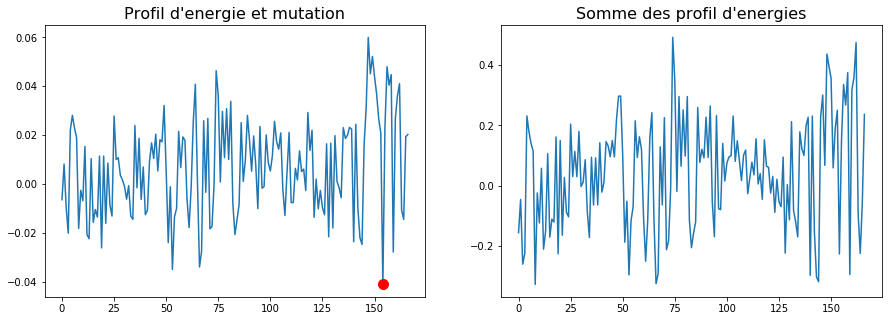

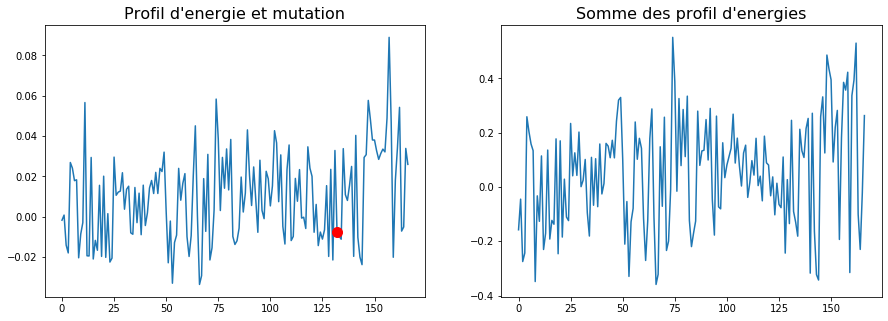

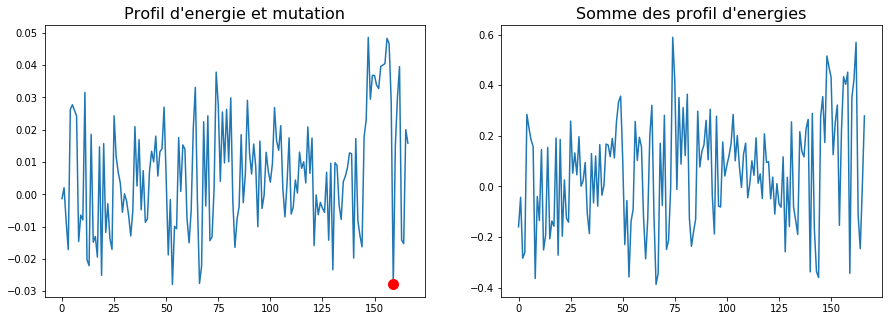

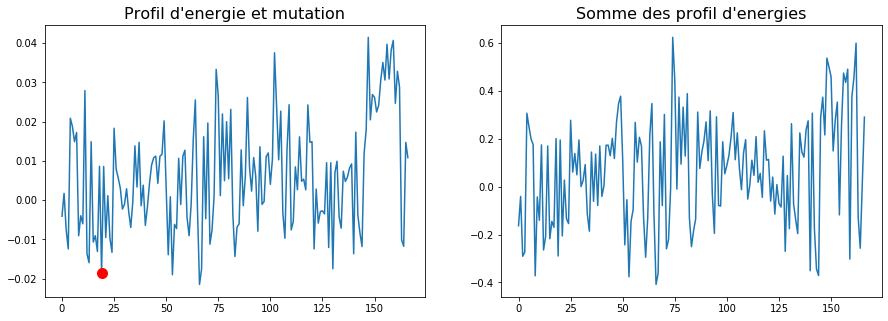

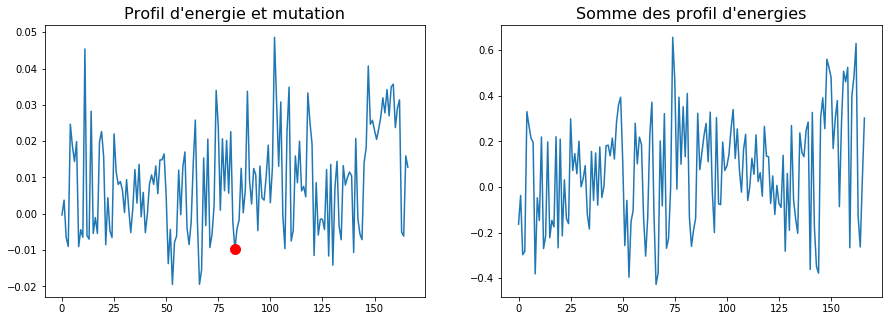

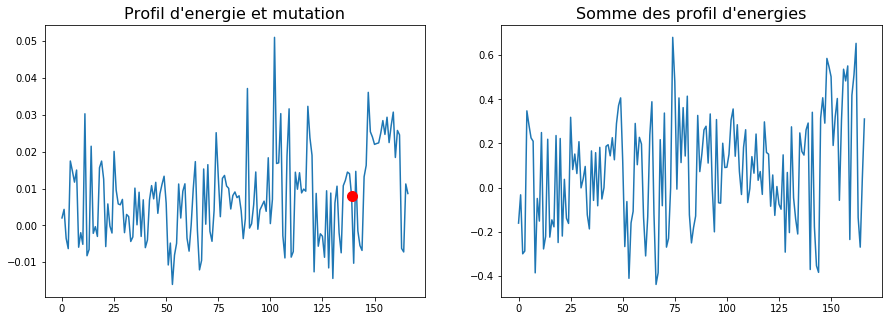

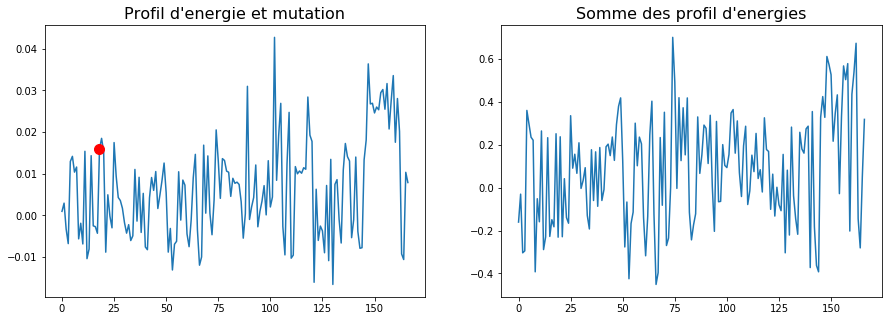

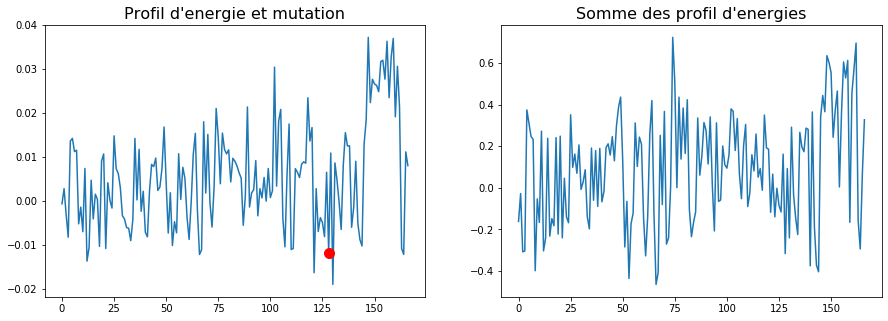

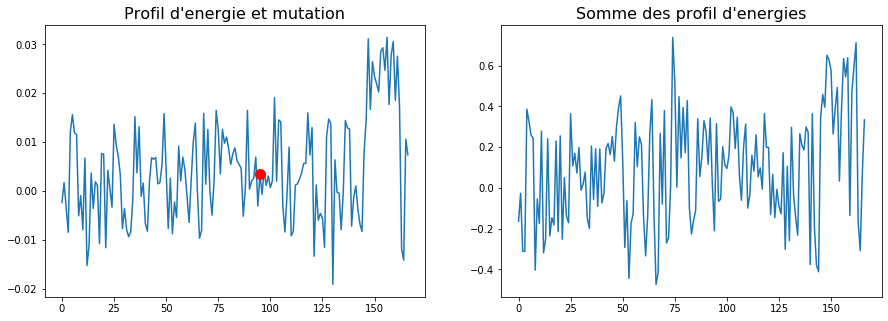

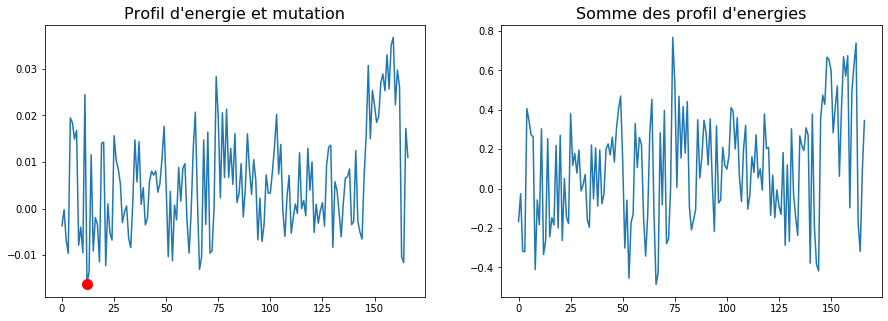

In [616]:
length = 167
repeat = 101

energy = pd.read_csv('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/energy.txt', names=['indexes', 'energy']).energy.values
penalties = np.zeros((501,))

energy_seq = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/used_energy_' + str(0) + '.npy')
mut_position = np.where(np.logical_and(energy_seq >= energy[0] - 0.00000001, energy_seq <= energy[0] + 0.00000001))[0][0]
penalties[mut_position] -= 1

energy_array = np.zeros((length, 4))

for step in range(1, 20):
    energy_seq = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/used_energy_' + str(step) + '.npy')
    energy_seq += penalties
    
    
    mut_position = np.where(np.logical_and(energy_seq >= energy[step] - 0.00000001, energy_seq <= energy[step] + 0.00000001))[0][0]
    penalties[mut_position] -= 1
    
    sequence = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(step) +'.npy')
    loc_energy_array = np.zeros((length, 4))

    for i in range(3):
        energy_array[np.arange(length), (sequence + i) % 4] += (energy_seq - energy[step - 1])[i::3] / 19.
        loc_energy_array[np.arange(length), (sequence + i) % 4] = (energy_seq - energy[step - 1])[i::3] / 19.
    
    fig = plt.figure(figsize=(15, 5))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Profil d'energie et mutation", fontsize=16)
    ax.plot(np.sum(loc_energy_array, axis=1))
    ax.plot([mut_position // 3],
              np.sum(loc_energy_array, axis=1)[mut_position // 3],
              linestyle='',
              marker='o',
              color='r',
              markersize=10)
    
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.set_title("Somme des profil d'energies", fontsize=16)
    ax1.plot(np.sum(energy_array, axis=1))
    fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/videos/construction_167_' + str(step) +'.png',
                format='png',
                bbox_inchesstr='tight')

In [23]:
def get_energy_sequence(length, repeat):
    energy = pd.read_csv('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/energy.txt', names=['indexes', 'energy']).energy.values
    penalties = np.zeros((3 * length,))
    energy_array = np.zeros((length, 4))

    energy_seq = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/used_energy_' + str(0) + '.npy')
    mut_position = np.where(np.logical_and(energy_seq >= energy[0] - 0.00000001, energy_seq <= energy[0] + 0.00000001))[0][0]
    penalties[mut_position] -= 1

    for step in range(1, 20):
        energy_seq = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/used_energy_' + str(step) + '.npy')
        energy_seq += penalties

        mut_position = np.where(np.logical_and(energy_seq >= energy[step] - 0.00000001, energy_seq <= energy[step] + 0.00000001))[0][0]
        penalties[mut_position] -= 1

        sequence = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(step) +'.npy')

        for i in range(3):
            energy_array[np.arange(length), (sequence + i) % 4] += np.abs((energy_seq - energy[step - 1])[i::3]) / 19.
    return energy_array

def get_energy_sequence_differential(length, repeat):
    energy_array_stay = np.zeros((length, 4))
    energy_array_AC = np.zeros((length, 4))
    energy_array_CA = np.zeros((length, 4))
    
    energy = pd.read_csv('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/energy.txt', names=['indexes', 'energy']).energy.values
    nb_steps = 1
    
    for step in range(1, nb_steps - 1):
        energy_seq = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/used_energy_' + str(step) + '.npy')
        position = get_mutation_pos(length, repeat, step)
        energy_seq[position] -= 1

        energy_seq -= energy[step - 1]
        sequence = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(step) +'.npy')

        sequence_A = sequence[sequence == 1]
        energy_array_stay[np.where(sequence == 1)[0], sequence_A] += energy_seq[::3][np.where(sequence == 1)[0]]  / nb_steps
        energy_array_AC[np.where(sequence == 1)[0], sequence_A + 1] += energy_seq[1::3][np.where(sequence == 1)[0]] / nb_steps
        energy_array_AC[np.where(sequence == 1)[0], sequence_A + 2] += energy_seq[2::3][np.where(sequence == 1)[0]] / nb_steps
        
        sequence_T = sequence[sequence == 2]
        energy_array_stay[np.where(sequence == 2)[0], sequence_T - 1] += energy_seq[2::3][np.where(sequence == 2)[0]] / nb_steps
        energy_array_AC[np.where(sequence == 2)[0], sequence_T] += energy_seq[::3][np.where(sequence == 2)[0]] / nb_steps
        energy_array_AC[np.where(sequence == 2)[0], sequence_T + 1] += energy_seq[1::3][np.where(sequence == 2)[0]] / nb_steps
        
        sequence_G = sequence[sequence == 3]
        energy_array_CA[np.where(sequence == 3)[0], sequence_G - 2] += energy_seq[1::3][np.where(sequence == 3)[0]] / nb_steps
        energy_array_CA[np.where(sequence == 3)[0], sequence_G - 3] += energy_seq[2::3][np.where(sequence == 3)[0]] / nb_steps
        energy_array_stay[np.where(sequence == 3)[0], sequence_G] += energy_seq[::3][np.where(sequence == 3)[0]] / nb_steps
        
        sequence_C = sequence[sequence == 4]
        energy_array_CA[np.where(sequence == 4)[0], sequence_C - 4] += energy_seq[::3][np.where(sequence == 4)[0]] / nb_steps
        energy_array_CA[np.where(sequence == 4)[0], sequence_C - 3] += energy_seq[1::3][np.where(sequence == 4)[0]] / nb_steps
        energy_array_stay[np.where(sequence == 4)[0], sequence_C - 2] += energy_seq[2::3][np.where(sequence == 4)[0]] / nb_steps

    return np.sum(energy_array_stay, axis=1), np.sum(energy_array_AC, axis=1), np.sum(energy_array_CA, axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


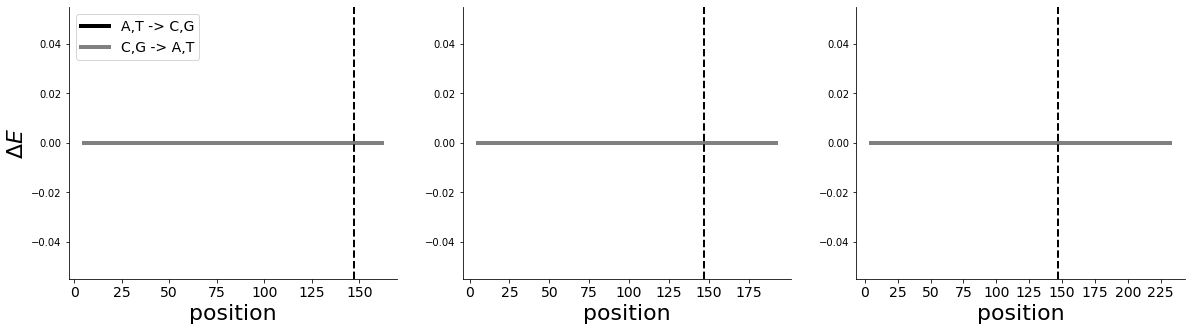

In [618]:
length = 167
fontsize = 14

energy_array_stay = np.zeros((length,))
energy_array_AC = np.zeros((length,))
energy_array_CA = np.zeros((length,))

for i in range(101, 444):
    energy_array_stay_, energy_array_AC_, energy_array_CA_ = get_energy_sequence_differential(length, i)
    energy_array_stay += energy_array_stay_ / 343.
    energy_array_AC += energy_array_AC_ / 343.
    energy_array_CA += energy_array_CA_ / 343.

window=10
    
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)

ax.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_array_AC, window), axis=1),
        color='k',
        linewidth=4,
        label='A,T -> C,G')

ax.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_array_CA, window), axis=1),
        color='grey',
        linewidth=4,
        label='C,G -> A,T')

#ax.set_ylim([0, 0.45])
ax.axvline(x=147, linestyle='--', color='k', linewidth=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, length, 25))
ax.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
#ax.set_yticks(np.arange(0.0, 0.45, 0.1))
#ax.set_yticklabels(np.round(np.arange(0.0, 0.45, 0.1), 3), fontsize=fontsize)
ax.set_xlabel('position', fontsize=fontsize + 8)
ax.legend(fontsize=fontsize)

ax.set_ylabel(r'$\Delta E$', fontsize=fontsize + 8)
#ax.text(x=-40, y=0.4, s='(a)', fontsize=fontsize + 14)

length = 197

energy_array_stay = np.zeros((length,))
energy_array_AC = np.zeros((length,))
energy_array_CA = np.zeros((length,))

for i in range(101, 400):
    energy_array_stay_, energy_array_AC_, energy_array_CA_ = get_energy_sequence_differential(length, i)
    energy_array_stay += energy_array_stay_ / 299.
    energy_array_AC += energy_array_AC_ / 299.
    energy_array_CA += energy_array_CA_ / 299.

window=10
    
ax1 = fig.add_subplot(1, 3, 2)

ax1.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_array_AC, window), axis=1),
        color='k',
        linewidth=4,
        label='A,T -> C,G')

ax1.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_array_CA, window), axis=1),
        color='grey',
        linewidth=4,
        label='C,G -> A,T')


#ax1.set_ylim([0, 0.45])
ax1.axvline(x=147, linestyle='--', color='k', linewidth=2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(0, length, 25))
ax1.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
#ax1.set_yticks(np.arange(0.0, 0.45, 0.1))
#ax1.set_yticklabels(np.round(np.arange(0.0, 0.45, 0.1), 3), fontsize=fontsize)
ax1.set_xlabel('position', fontsize=fontsize + 8)

#ax1.text(x=-50, y=0.4, s='(b)', fontsize=fontsize + 14)

length = 237

energy_array_stay = np.zeros((length,))
energy_array_AC = np.zeros((length,))
energy_array_CA = np.zeros((length,))

for i in range(101, 391):
    energy_array_stay_, energy_array_AC_, energy_array_CA_ = get_energy_sequence_differential(length, i)
    energy_array_stay += energy_array_stay_ / 290.
    energy_array_AC += energy_array_AC_ / 290.
    energy_array_CA += energy_array_CA_ / 290.

window=10
    
ax2 = fig.add_subplot(1, 3, 3)

ax2.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_array_AC, window), axis=1),
        color='k',
        linewidth=4,
        label='A,T -> C,G')

ax2.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_array_CA, window), axis=1),
        color='grey',
        linewidth=4,
        label='C,G -> A,T')


#ax2.set_ylim([0, 0.45])
ax2.axvline(x=147, linestyle='--', color='k', linewidth=2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks(np.arange(0, length, 25))
ax2.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
#ax2.set_yticks(np.arange(0.0, 0.45, 0.1))
#ax2.set_yticklabels(np.round(np.arange(0.0, 0.45, 0.1), 3), fontsize=fontsize)
ax2.set_xlabel('position', fontsize=fontsize + 8)

#ax2.text(x=-60, y=0.4, s='(c)', fontsize=fontsize + 14)
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/estimated_gain_loc_diff.eps', format='eps', bbox_inchesstr='tight')
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/estimated_gain_loc_diff.png', format='png', bbox_inchesstr='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


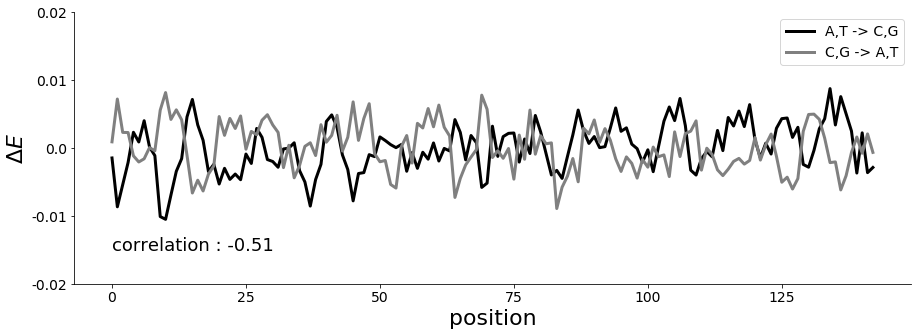

In [423]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

ecart_moyenne_AC = (energy_array_AC[window // 2 : length - (window // 2 - 1 + (window % 2))] - np.mean(rolling_window(energy_array_AC, window), axis=1))[: 147]
ecart_moyenne_CA = (energy_array_CA[window // 2 : length - (window // 2 - 1 + (window % 2))] - np.mean(rolling_window(energy_array_CA, window), axis=1))[: 147]

window = 5
ax.plot(np.mean(rolling_window(ecart_moyenne_AC, window), axis=1),
        color='k',
        linewidth=3,
        label='A,T -> C,G')

ax.plot(np.mean(rolling_window(ecart_moyenne_CA, window), axis=1),
        color='grey',
        linewidth=3,
        label='C,G -> A,T')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 147, 25))
ax.set_xticklabels(np.arange(0, 147, 25), fontsize=fontsize)
ax.set_yticks(np.arange(-0.02, 0.03, 0.01))
ax.set_yticklabels(np.round(np.arange(-0.02, 0.03, 0.01), 3), fontsize=fontsize)
ax.set_xlabel('position', fontsize=fontsize + 8)
ax.set_ylabel(r'$\Delta E$', fontsize=fontsize + 8)
ax.legend(fontsize=fontsize)

correlation = np.round(np.corrcoef(np.mean(rolling_window(ecart_moyenne_AC, window), axis=1),
                                   np.mean(rolling_window(ecart_moyenne_CA, window), axis=1))[0, 1], 2)
ax.text(x=0, y=-0.015, s='correlation : {}'.format(correlation), fontsize=fontsize + 4)

fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/anti_correlation_AC_CA_in_core.eps', format='eps', bbox_inchesstr='tight')
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/anti_correlation_AC_CA_in_core.png', format='png', bbox_inchesstr='tight')

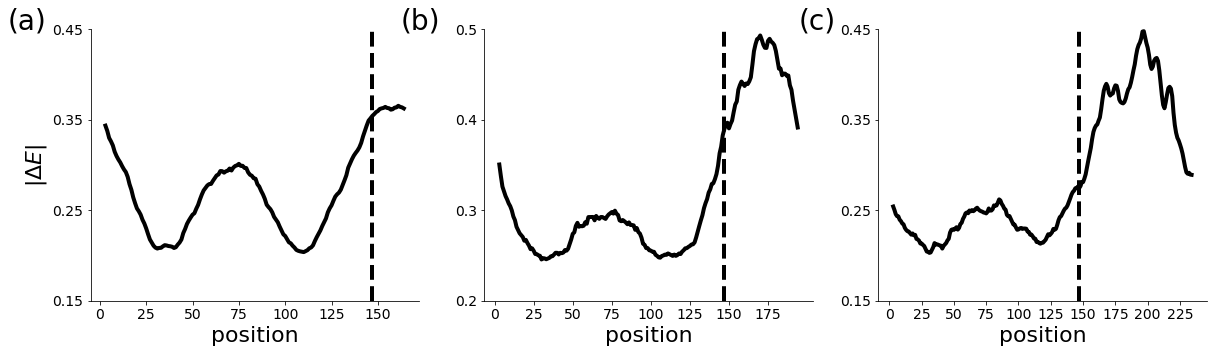

In [635]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
fontsize = 14
linewidth = 4

length = 167
energy_gain_per_pos = np.zeros((length, 4))

for i in range(101, 444):
    energy_gain_per_pos += get_energy_sequence(length, i)
    
energy_gain_per_pos /= 343.
energy_gain_per_pos = np.sum(energy_gain_per_pos, axis=1)

window = 6
ax.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_gain_per_pos, window), axis=1),
        color='k',
        linewidth=linewidth,
        label='rolling mean')

ax.axvline(x=147, linestyle='--', color='k', linewidth=linewidth)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, length, 25))
ax.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
ax.set_ylim(0.15, 0.45)
ax.set_yticks(np.arange(0.15, 0.55, 0.1))
ax.set_yticklabels(np.round(np.arange(0.15, 0.55, 0.1), 3), fontsize=fontsize)
ax.set_xlabel('position', fontsize=fontsize + 8)
ax.set_ylabel(r'|$\Delta E$|', fontsize=fontsize + 8)
ax.text(x=-50, y=0.45, s='(a)', fontsize=fontsize + 14)

ax1 = fig.add_subplot(1, 3, 2)
length = 197
energy_gain_per_pos = np.zeros((length, 4))

for i in range(101, 400):
    energy_gain_per_pos += get_energy_sequence(length, i)

energy_gain_per_pos /= 299.
energy_gain_per_pos = np.sum(energy_gain_per_pos, axis=1)

ax1.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
         np.mean(rolling_window(energy_gain_per_pos, window), axis=1),
         color='k',
         linewidth=linewidth,
         label='rolling mean')


ax1.axvline(x=147, linestyle='--', color='k', linewidth=linewidth)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(0, length, 25))
ax1.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
ax1.set_ylim(0.2, 0.5)
ax1.set_yticks(np.arange(0.2, 0.6, 0.1))
ax1.set_yticklabels(np.round(np.arange(0.2, 0.6, 0.1), 3), fontsize=fontsize)
ax1.set_xlabel('position', fontsize=fontsize + 8)
ax1.text(x=-60, y=0.5, s='(b)', fontsize=fontsize + 14)

ax2 = fig.add_subplot(1, 3, 3)
length = 237
energy_gain_per_pos = np.zeros((length, 4))

for i in range(101, 317):
    energy_gain_per_pos += get_energy_sequence(length, i)

energy_gain_per_pos /= 216.
energy_gain_per_pos = np.sum(energy_gain_per_pos, axis=1)

ax2.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
         np.mean(rolling_window(energy_gain_per_pos, window), axis=1),
         color='k',
         linewidth=linewidth,
         label='rolling mean')


ax2.axvline(x=147, linestyle='--', color='k', linewidth=linewidth)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks(np.arange(0, length, 25))
ax2.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
ax2.set_ylim(0.15, 0.45)
ax2.set_yticks(np.arange(0.15, 0.55, 0.1))
ax2.set_yticklabels(np.round(np.arange(0.15, 0.55, 0.1), 3), fontsize=fontsize)
ax2.set_xlabel('position', fontsize=fontsize + 8)
ax2.text(x=-70, y=0.45, s='(c)', fontsize=fontsize + 14)#

fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/estimated_gain_localization.eps', format='eps', bbox_inchesstr='tight')
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/estimated_gain_localization.png', format='png', bbox_inchesstr='tight')

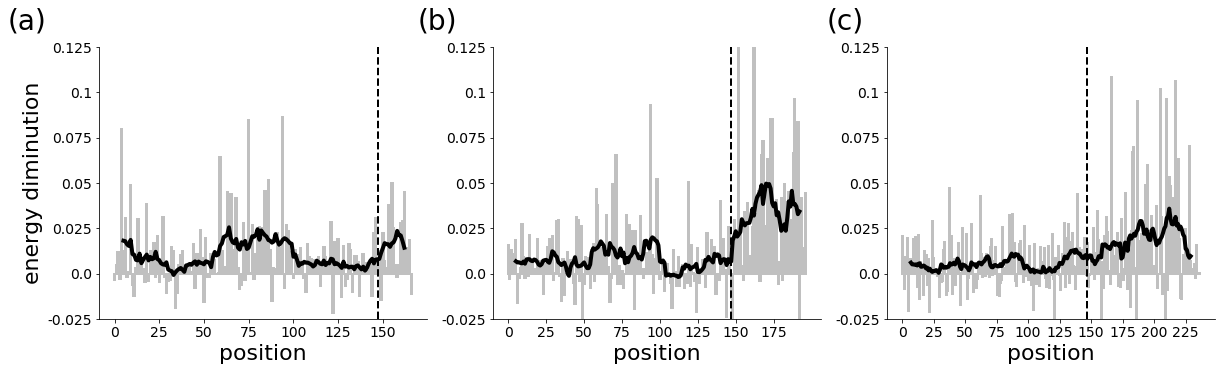

In [330]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)

length = 167
energy_gain_per_pos = np.zeros((length,))

for i in range(1, 22):
    energy_gain_per_pos += get_energy_gain_per_pos(length, i)
    
energy_gain_per_pos /= 22.

ax.bar(np.arange(length),
       energy_gain_per_pos,
       color='silver',
       edgecolor='silver',
       linewidth=2)

window = 10
ax.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_gain_per_pos, window), axis=1),
        color='k',
        linewidth=4,
        label='rolling mean')

ax.set_ylim(-0.025, 0.125)
ax.axvline(x=147, linestyle='--', color='k', linewidth=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, length, 25))
ax.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
ax.set_yticks(np.arange(-0.025, 0.15, 0.025))
ax.set_yticklabels(np.round(np.arange(-0.025, 0.15, 0.025), 3), fontsize=fontsize)
ax.set_xlabel('position', fontsize=fontsize + 8)
ax.set_ylabel('energy diminution', fontsize=fontsize + 8)
ax.text(x=-60, y=0.135, s='(a)', fontsize=fontsize + 14)

ax1 = fig.add_subplot(1, 3, 2)
length = 197
energy_gain_per_pos = np.zeros((length,))

for i in range(1, 25):
    energy_gain_per_pos += get_energy_gain_per_pos(length, i)

energy_gain_per_pos /= 24.

ax1.bar(np.arange(length),
       energy_gain_per_pos,
       color='silver',
       edgecolor='silver',
       linewidth=2)

ax1.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_gain_per_pos, window), axis=1),
        color='k',
        linewidth=4,
        label='rolling mean')

ax1.set_ylim(-0.025, 0.125)
ax1.axvline(x=147, linestyle='--', color='k', linewidth=2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(0, length, 25))
ax1.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
ax1.set_yticks(np.arange(-0.025, 0.15, 0.025))
ax1.set_yticklabels(np.round(np.arange(-0.025, 0.15, 0.025), 3), fontsize=fontsize)
ax1.set_xlabel('position', fontsize=fontsize + 8)
ax1.text(x=-60, y=0.135, s='(b)', fontsize=fontsize + 14)

ax2 = fig.add_subplot(1, 3, 3)
length = 237
energy_gain_per_pos = np.zeros((length,))

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]:
    energy_gain_per_pos += get_energy_gain_per_pos(length, i)

energy_gain_per_pos /= 18.

ax2.bar(np.arange(length),
     energy_gain_per_pos,
       color='silver',
       edgecolor='silver',
       linewidth=2)
window=15
ax2.plot(np.arange(window // 2, length - (window // 2 - 1 + (window % 2))),
        np.mean(rolling_window(energy_gain_per_pos, window), axis=1),
        color='k',
        linewidth=4,
        label='rolling mean')

ax2.set_ylim(-0.025, 0.125)
ax2.axvline(x=147, linestyle='--', color='k', linewidth=2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks(np.arange(0, length, 25))
ax2.set_xticklabels(np.arange(0, length, 25), fontsize=fontsize)
ax2.set_yticks(np.arange(-0.025, 0.15, 0.025))
ax2.set_yticklabels(np.round(np.arange(-0.025, 0.15, 0.025), 3), fontsize=fontsize)
ax2.set_xlabel('position', fontsize=fontsize + 8)
ax2.text(x=-60, y=0.135, s='(c)', fontsize=fontsize + 14)

fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/energie_gain_localization.eps', format='eps', bbox_inchesstr='tight')
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/energie_gain_localization.png', format='png', bbox_inchesstr='tight')

In [335]:
length = 237
mutation = []
energies = np.concatenate([get_mutation_sequence(length, i)[2] for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]])
threshold = np.percentile(energies, q=99.5) - 0.02

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]:
    position, _, energy = get_mutation_sequence(length, i)
    position = position[energy > threshold]
    moments = np.where(energy > threshold)[0]
        
    for pos, moment in zip(position, moments):
        seq_before = convert_seq(np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(i) + '/designed_sequence_' + str(moment) + '.npy')[pos - 2 : pos + 3])
        seq_after = convert_seq(np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(i) + '/designed_sequence_' + str(moment + 1) + '.npy')[pos - 2 : pos + 3])
        print(str(pos) + ' : ' +  seq_before + ' --> ' + seq_after)

217 : GGTAC --> GGGAC
40 : TTATC --> TTGTC
195 : CCAGT --> CCGGT
38 : AAAAA --> AAGAA
219 : GCTAA --> GCGAA
210 : GGTGC --> GGCGC
184 : TTCTT --> TTTTT
205 : TACAT --> TATAT
217 : TCGAG --> TCTAG
228 : TAGTT --> TAATT
166 : CCTGT --> CCCGT
85 : TTTTA --> TTGTA
162 : AGCGA --> AGAGA
183 : AAGTC --> AAATC
193 : ACAGC --> ACCGC
184 : TAGTA --> TATTA
215 : TTGAT --> TTAAT
187 : ACAGC --> ACCGC
166 : CGAGT --> CGCGT
80 : TTATT --> TTCTT
71 : CTATA --> CTGTA
155 : CGTGT --> CGGGT
196 : GTGTT --> GTTTT
204 : CCACG --> CCGCG


#### What are the typical sequences in the optimized linker ?

In [19]:
def get_final_seq(length, repeat):
    energy = pd.read_csv('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/energy.txt', names=['indexes', 'energy']).energy.values
    return np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(np.argmin(energy)) + '.npy')

def get_first_seq(length, repeat):
    return np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_0.npy')

def convert_seq(sequence):
    converter = {1 : 'A', 2 : 'T', 3 : 'G', 4 : 'C'}
    return ''.join([converter[num] for num in sequence])


In [19]:
def get_statistic(length, max_repeat, motif, position, seq_type):
    assert position in ['dyad', 'linker'],ValueError('position must be dyad or linker')
    assert motif in ['AAAAA', 'CGCGC'], ValueError('motif must be AAAAA or CGCGC')
    assert seq_type in ['best', 'random'], ValueError('seq_type must be best or random')

    if motif == 'AAAAA':
        motif, rev_motif = [1, 1, 1, 1, 1], [2, 2, 2, 2, 2]
    else:
        motif, rev_motif = [3, 4, 3, 4, 3], [4, 3, 4, 3, 4]

    if position == 'linker':
        position = np.arange(147, length)
    else:
        position = np.arange(50, 100)

    counter = 0
    for repeat in range(101, max_repeat):
        if seq_type == 'best':
            sequence = get_final_seq(length, repeat)[position]
        else:
            sequence = get_first_seq(length, repeat)[position]
        condition = (np.sum(np.abs((rolling_window(sequence, 5) - motif)), axis=1) == 0).any()
        rev_condition = (np.sum(np.abs((rolling_window(sequence, 5) - rev_motif)), axis=1) == 0).any()

        if condition or rev_condition:
            counter += 1
    return counter / (max_repeat)

In [20]:
import itertools
max_repeat = {167 : 778, 197 : 713, 237 : 534}

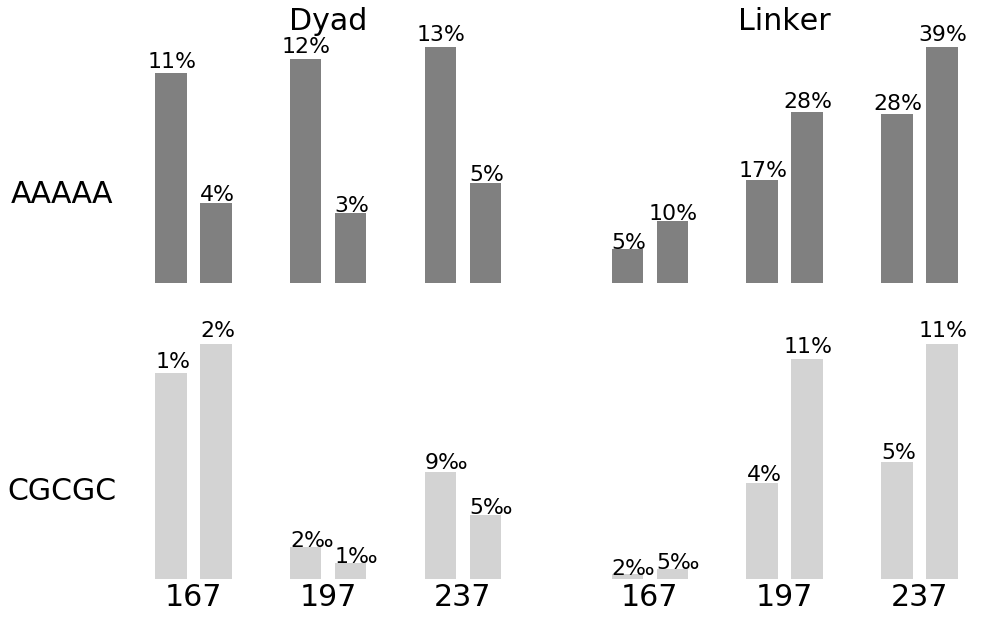

In [1073]:
fig = plt.figure(figsize=(15, 10))
j = 0

for motif, position in itertools.product(*[['AAAAA', 'CGCGC'], ['dyad', 'linker']]):
    j += 1
    
    if j in [1, 2]:
        color='grey'
    else:
        color='lightgrey'
    
    ax = fig.add_subplot(2, 2, j)

    heights = np.array([get_statistic(length, max_repeat[length], motif, position, seq_type)\
                       for length, seq_type in itertools.product(*[[167, 197, 237], ['random', 'best']])])

    height = np.zeros(8)
    height[:2] = heights[:2]
    height[3:5] = heights[2:4]
    height[6:] = heights[4:]

    width = 0.7

    ax.bar(x=np.arange(len(height)), height=height, width=width, color=color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])

    if j in [3, 4]:
        ax.set_xticks([0.5, 3.5, 6.5])
        ax.set_xticklabels([167, 197, 237], fontsize=30)
        ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_yticks([])
    
    if j in [1, 3]:
        ax.yaxis.set_label_coords(-0.2, 0.3)
        ax.set_ylabel(motif,
                      fontsize=30,
                      rotation=0)
    if j in [1, 2]:
        ax.set_title(position.capitalize(),
                     fontsize=30)

    for i, v in enumerate(height):
        if i not in [2, 5]:
            if v > 0.1:
                s = str(int(v * 100)) + '%'
                x = i - 3 * width / 4
            elif v > 0.01:
                s = str(int(v * 100)) + '%'
                x = i - width / 2
            else:
                x = i - width / 2
                s = str(int(v * 1000)) + '‰'
            ax.text(x=x, y=v + 0.03 * v, s=s, fontsize=22)

fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/evolution_motifs_in_region.png', format='png')
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/evolution_motifs_in_region.eps', format='eps')

In [67]:
def return_energy_seq(length, repeat, steps):
    energy = pd.read_csv('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/energy.txt', names=['indexes', 'energy']).energy.values
    penalties = np.zeros((3 * length,))

    energy_seq = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/used_energy_' + str(0) + '.npy')
    mut_position = np.where(np.logical_and(energy_seq >= energy[0] - 0.00000001, energy_seq <= energy[0] + 0.00000001))[0][0]
    penalties[mut_position] -= 1

    if steps == 0:
        return energy_seq
    for step in range(1, steps + 1):
        energy_seq = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/used_energy_' + str(step) + '.npy')
        energy_seq += penalties

        mut_position = np.where(np.logical_and(energy_seq >= energy[step] - 0.00000001, energy_seq <= energy[step] + 0.00000001))[0][0]
        penalties[mut_position] -= 1
        energy_seq -= energy[step - 1]

    return energy_seq

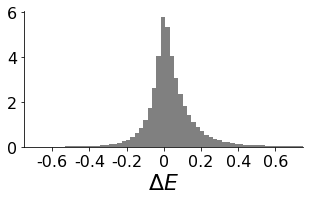

In [566]:
fig = plt.figure(figsize=(5, 2.5))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-0.75, 0.75])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'$\Delta E$', fontsize=22)
ax.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
ax.set_xticklabels([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6], fontsize=16)
ax.set_yticks([0, 2, 4, 6])
ax.set_yticklabels([0, 2, 4, 6], fontsize=16)

ax.hist(deltaE_all_values.flatten(), bins=300, density=True, color='grey')
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/distribution_energy.eps', format='eps', bbox_to_anchor=(5, 3))
fig.savefig('/users/invites/routhier/Documents/Presentations/Article_sequence_design/distribution_energy.png', format='png', bbox_to_anchor=[[1, 1], [3, 7]])

In [459]:
max_depth = 778
length = 167

def return_all_scores(length, max_depth):
    deltaE_all_values = np.zeros((max_depth - 101, 19, 3 * length))

    for repeat, steps in itertools.product(*[range(101, max_depth), range(1, 20)]):
        deltaE_all_values[repeat - 101, steps - 1] = return_energy_seq(length, repeat, steps)

    return deltaE_all_values

def return_mutations(deltaE_all_values, mid_size=4, delta='negative', mutation='after', site='dyad', threshold=1):
    if delta == 'negative':
        repeats, steps, positions = np.where(deltaE_all_values < -threshold)
    else:
        repeats, steps, positions = np.where(deltaE_all_values > threshold)

    repeats += 101
    steps += 1
    filename = "/users/invites/routhier/Documents/sequence_design/mutation_" + str(length) + '_' + site + '_' + delta + '_' + mutation  + ".npy"
    mutations = []
    with open("/users/invites/routhier/Documents/sequence_design/best_sequences_" + str(length) + '_' + site + '_' + delta + '_' + mutation  + ".fa", "w")\
    as output_handle:

        for repeat, step, pos in zip(repeats, steps, positions):
            seq_pos = pos // 3
            mut = pos % 3

            if site == 'dyad':
                min_pos = 50
                max_pos = 100
            else:
                min_pos = 147
                max_pos = length - mid_size - 1

            if seq_pos <= max_pos and seq_pos >= min_pos:
                output_handle.write('>repeat' + str(repeat) + '_step' + str(step) + ':' + str(seq_pos - mid_size) + '-' + str(seq_pos + mid_size) + '_mut' + str(mut) + '\n')
                seq_before = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(step) + '.npy')[seq_pos - mid_size : seq_pos + mid_size + 1]
                seq_after = np.copy(seq_before)
                seq_after[mid_size] = (seq_after[mid_size] + mut) % 4 + 1

                if mutation =='after':
                    mutations.append(seq_after)
                    output_handle.write(convert_seq(seq_after) + '\n')
                else:
                    mutations.append(seq_before)
                    output_handle.write(convert_seq(seq_before) + '\n')
    #mutations = np.array(mutations)
    #np.save(filename, mutations)

In [460]:
for length, max_depth in zip([167, 197, 237], [778, 719, 534]):
    deltaE_all_values = return_all_scores(length, max_depth)

    for delta, mutation, site in itertools.product(*[['negative', 'positive'], ['after', 'before'], ['linker', 'dyad']]):
        return_mutations(deltaE_all_values, mid_size=2, delta=delta, mutation=mutation, site=site, threshold=0.5)

In [461]:
for delta, mutation, site in itertools.product(*[['negative', 'positive'], ['after', 'before'], ['linker', 'dyad']]):
    with open("/users/invites/routhier/Documents/sequence_design/sequences_" + site + '_' + delta + '_' + mutation  + ".fa", "w") as output_handle:

        for length in  [167, 197, 237]:
            line = 1
            with open("/users/invites/routhier/Documents/sequence_design/best_sequences_" + str(length) + '_' + site + '_' + delta + '_' + mutation  + ".fa", "r") as input_handle:
                while line:
                    line = input_handle.readline()
                    if line.startswith('>'):
                        output_handle.write('>length' + str(length) + '_' + line[1:])
                    else:
                        output_handle.write(line)

In [183]:
def return_mutations(delta, site):
    mutation = 'after'
    mutations = np.concatenate([np.load("/users/invites/routhier/Documents/sequence_design/mutation_" + str(length) + '_' + site + '_' + delta + '_' + mutation  + ".npy")\
                                for length in [167, 197, 237]], axis=0)
    mutations = (np.arange(4) == mutations[..., None]-1).astype(int)

    mutation = 'before'
    before_mutations = np.concatenate([np.load("/users/invites/routhier/Documents/sequence_design/mutation_" + str(length) + '_' + site + '_' + delta + '_' + mutation  + ".npy")\
                                for length in [167, 197, 237]], axis=0)
    before_mutations = (np.arange(4) == before_mutations[..., None]-1).astype(int)
    return mutations, before_mutations

In [15]:
def reverse_tensor(mut):
    mut = mut[:, :, ::-1]
    value = np.reshape(np.where(mut == 1)[2], (len(mut), 5))
    
    value[value == 0] = 4 
    value[value == 1] = 5
    value[value == 2] = 6
    value[value == 3] = 7

    value[value == 4] = 1 
    value[value == 5] = 0
    value[value == 6] = 3
    value[value == 7] = 2
    return (np.arange(4) == value[..., None]).astype(int)

def reverse(mut):
    mut = mut[::-1]
    value = np.where(mut == 1)[1]

    value[value == 0] = 4 
    value[value == 1] = 5
    value[value == 2] = 6
    value[value == 3] = 7

    value[value == 4] = 1 
    value[value == 5] = 0
    value[value == 6] = 3
    value[value == 7] = 2
    return (np.arange(4) == value[..., None]).astype(int)

def distance(mut1, mut2):
    return min(np.sum((mut1 - mut2) ** 2), np.sum((mut1 - reverse(mut2)) ** 2))

#affinity = np.array([[distance(mut1, mut2) for mut1 in mutations] for mut2 in mutations])

In [8]:
def change_distance(mut, selected_mut):
    mut_rc = reverse(mut)
    rc_distance = np.mean([np.sum((mut_rc - mut_l) ** 2) for mut_l in selected_mut])
    d_distance = np.mean([np.sum((mut - mut_l) ** 2) for mut_l in selected_mut])
    return rc_distance - d_distance

In [216]:
from sklearn.cluster import DBSCAN

def return_logos(mutations, before_mutations, affinity):
    n_clusters = 20

    #labels = AgglomerativeClustering(n_clusters,
    #                                 affinity='precomputed',
    #                                 linkage='average').fit_predict(affinity)
    
    labels = DBSCAN(eps=0.2, metric='precomputed').fit_predict(affinity)
    
    for i in np.unique(labels):
        #if len(labels[labels == i]) / len(labels) > 0.05:
        print(len(labels[labels == i]) / len(labels))
        if i != -1:
            selected_mut = np.copy(mutations[labels == i])
            before_selected_mut = np.copy(before_mutations[labels == i])
            for j, mut in enumerate(selected_mut):
                if change_distance(mut, selected_mut) < 0:
                    selected_mut[j] = reverse(mut)
                    before_selected_mut[j] = reverse(before_selected_mut[j])
            plot_logo(create_logos(np.mean(selected_mut, axis=0)))
            plot_logo(create_logos(np.mean(before_selected_mut, axis=0)))

In [55]:
def calculate_distance(mutations):
    helper_array = np.zeros((len(mutations), len(mutations), 5, 4))
    helper_array_T = np.zeros((len(mutations), len(mutations), 5, 4))
    reverse_array_T = np.zeros((len(mutations), len(mutations), 5, 4))
    reverse_mutation = reverse_tensor(mutations)

    for i in range(len(helper_array)):
        helper_array[i] = mutations
        helper_array_T[:, i] = mutations
        reverse_array_T[:, i] = reverse_mutation

    d_distance = np.sum(np.sum((helper_array - helper_array_T)**2, axis=3), axis=2)
    rc_distance = np.sum(np.sum((helper_array - reverse_array_T)**2, axis=3), axis=2)
    return np.minimum(d_distance, rc_distance)

In [211]:
mutations_linker_positive, before_linker_positive = return_mutations('positive', 'linker')
#sampling_linker_positive = np.random.randint(0, len(mutations_linker_positive), 10000)
#affinity_linker_positive = calculate_distance(mutations_linker_positive[sampling_linker_positive])

mutations_dyad_positive, before_dyad_positive = return_mutations('positive', 'dyad')
#sampling_dyad_positive = np.random.randint(0, len(mutations_dyad_positive), 10000)
#affinity_dyad_positive = calculate_distance(mutations_dyad_positive[sampling_dyad_positive])

mutations_dyad_negative, before_dyad_negative = return_mutations('negative', 'dyad')
sampling_dyad_negative = np.random.randint(0, len(mutations_dyad_negative), 100)
affinity_dyad_negative = calculate_distance(before_dyad_negative[sampling_dyad_negative])

0.1247


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


0.1371
0.0951
0.0718
0.1748
0.1451
0.0878


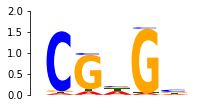

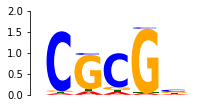

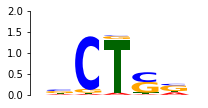

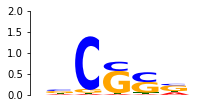

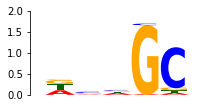

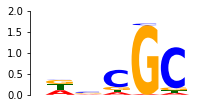

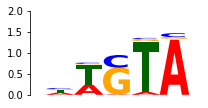

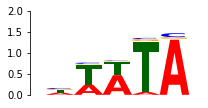

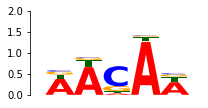

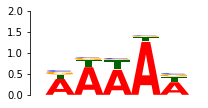

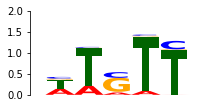

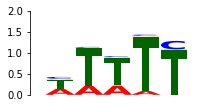

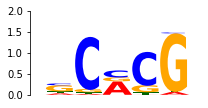

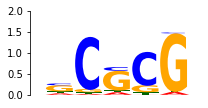

In [79]:
return_logos(mutations_linker_positive[sampling_linker_positive], before_linker_positive[sampling_linker_positive], affinity_linker_positive)

0.1375
0.1393
0.1207
0.1442
0.1552
0.1318


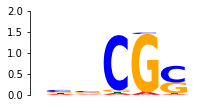

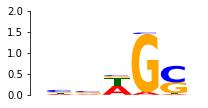

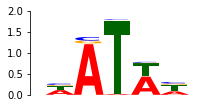

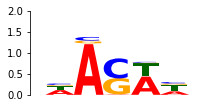

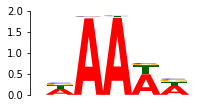

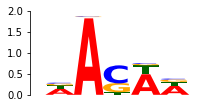

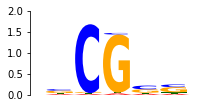

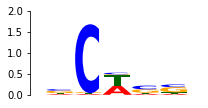

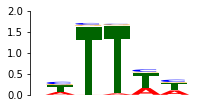

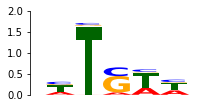

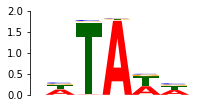

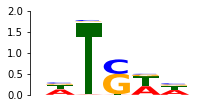

In [80]:
return_logos(mutations_dyad_positive[sampling_dyad_positive], before_dyad_positive[sampling_dyad_positive], affinity_dyad_positive)

In [217]:
return_logos(mutations_dyad_negative[sampling_dyad_negative],
             before_dyad_negative[sampling_dyad_negative],
             affinity_dyad_negative)

1.0


### STREME advanced usage

In [474]:
def return_control(deltaE_all_values, mid_size=2, mutation='before', site='dyad', threshold=1):
    repeats, steps, positions = np.where(np.logical_and(deltaE_all_values > -0.003, deltaE_all_values < 0.003))

    repeats += 101
    steps += 1
    with open("/users/invites/routhier/Documents/sequence_design/control_sequences_" + str(length) + '_' + site + '_' + mutation  + ".fa", "w")\
    as output_handle:

        for repeat, step, pos in zip(repeats, steps, positions):
            seq_pos = pos // 3
            mut = pos % 3

            if site == 'dyad':
                min_pos = 50
                max_pos = 100
            else:
                min_pos = 147
                max_pos = length - mid_size - 1

            if seq_pos <= max_pos and seq_pos >= min_pos:
                output_handle.write('>repeat' + str(repeat) + '_step' + str(step) + ':' + str(seq_pos - mid_size) + '-' + str(seq_pos + mid_size) + '_mut' + str(mut) + '\n')
                seq_before = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(step) + '.npy')[seq_pos - mid_size : seq_pos + mid_size + 1]
                seq_after = np.copy(seq_before)
                seq_after[mid_size] = (seq_after[mid_size] + mut) % 4 + 1

                if mutation =='after':
                    output_handle.write(convert_seq(seq_after) + '\n')
                else:
                    output_handle.write(convert_seq(seq_before) + '\n')

In [475]:
for length, max_depth in zip([167, 197, 237], [778, 719, 534]):
    deltaE_all_values = return_all_scores(length, max_depth)

    for mutation, site in itertools.product(*[['after', 'before'], ['linker', 'dyad']]):
        return_control(deltaE_all_values, mid_size=2, mutation=mutation, site=site, threshold=0.5)

In [477]:
for mutation, site in itertools.product(*[['after', 'before'], ['linker', 'dyad']]):
    with open("/users/invites/routhier/Documents/sequence_design/control_sequences_" + site + '_' + mutation  + ".fa", "w") as output_handle:

        for length in  [167, 197, 237]:
            line = 1
            with open("/users/invites/routhier/Documents/sequence_design/control_sequences_" + str(length) + '_' + site + '_' + mutation  + ".fa", "r") as input_handle:
                while line:
                    line = input_handle.readline()
                    if line.startswith('>'):
                        output_handle.write('>length' + str(length) + '_' + line[1:])
                    else:
                        output_handle.write(line)

In [499]:
def str_to_onehot(letter_motif, strand='+'):
    if strand == '-':
        letter_motif = letter_motif.replace('A', 'B')
        letter_motif = letter_motif.replace('T', 'A')
        letter_motif = letter_motif.replace('G', 'D')
        letter_motif = letter_motif.replace('C', 'G')
        letter_motif = letter_motif.replace('B', 'T')
        letter_motif = letter_motif.replace('D', 'C')
        letter_motif = letter_motif[::-1]
    
    convert = {'A' : np.array([[1., 0., 0., 0.]]),
               'T' : np.array([[0., 1., 0., 0.]]),
               'G' : np.array([[0., 0., 1., 0.]]),
               'C' : np.array([[0., 0., 0., 1.]])}
    return np.concatenate([convert[letter] for letter in letter_motif], axis=0)

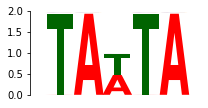

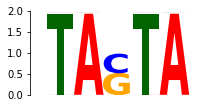

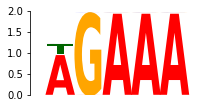

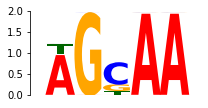

In [524]:
position = 'dyad'
mutation = 'negative'
control_mut = 'before'
limits = [50000, 20000, 5000, 1500, 15000, 7500, 7500, 404]
count = 0

for position, mutation, control_mut in zip(['linker', 'linker', 'dyad', 'dyad'],
                                           ['positive', 'negative', 'positive', 'negative'],
                                           ['before', 'after', 'after', 'before']):

    for number in [0, 1]:
        limit = limits[count]
        count += 1
        sequence_name = pd.read_csv('/users/invites/routhier/Documents/sequence_design/' + position + '_' + mutation + '_' + control_mut + '/fimo' + str(number) + '.tsv', sep='\t').sequence_name.values
        strands = pd.read_csv('/users/invites/routhier/Documents/sequence_design/' + position + '_' + mutation + '_' + control_mut + '/fimo' + str(number) + '.tsv', sep='\t').strand.values

        matching_motifs = []
        for record in SeqIO.parse("/users/invites/routhier/Documents/sequence_design/sequences_" + position + '_' + mutation + '_' + control_mut + ".fa", "fasta"):
            if record.id in sequence_name[:limit]:
                match = np.where(record.id == sequence_name)[0][0]
                strand = strands[match]

                matching_motifs.append(str_to_onehot(str(record.seq), strand)[None, :, :])

        matching_motifs = np.concatenate(matching_motifs, axis=0)
        plot_logo(create_logos(np.mean(matching_motifs, axis=0)))

        if control_mut == 'before':
            before_mut = 'after'
        elif control_mut == 'after':
            before_mut = 'before'

        matching_motifs = []
        for record in SeqIO.parse("/users/invites/routhier/Documents/sequence_design/sequences_" + position + '_' + mutation + '_' + before_mut + ".fa", "fasta"):
            if record.id in sequence_name[:limit]:
                match = np.where(record.id == sequence_name)[0][0]
                strand = strands[match]

                matching_motifs.append(str_to_onehot(str(record.seq), strand)[None, :, :])

        matching_motifs = np.concatenate(matching_motifs, axis=0)
        plot_logo(create_logos(np.mean(matching_motifs, axis=0)))

In [ ]:
def return_control(mid_size=2, delta='negative', mutation='after', site='dyad'):
    repeats += 101
    steps += 1
    filename = "/users/invites/routhier/Documents/sequence_design/mutation_" + str(length) + '_' + site + '_' + delta + '_' + mutation  + ".npy"
    mutations = []
    with open("/users/invites/routhier/Documents/sequence_design/best_sequences_" + str(length) + '_' + site + '_' + delta + '_' + mutation  + ".fa", "w")\
    as output_handle:

        for repeat, step, pos in zip(repeats, steps, positions):
            seq_pos = pos // 3
            mut = pos % 3

            if site == 'dyad':
                min_pos = 50
                max_pos = 100
            else:
                min_pos = 147
                max_pos = length - mid_size - 1

            if seq_pos <= max_pos and seq_pos >= min_pos:
                output_handle.write('>repeat' + str(repeat) + '_step' + str(step) + ':' + str(seq_pos - mid_size) + '-' + str(seq_pos + mid_size) + '_mut' + str(mut) + '\n')
                seq_before = np.load('./Results_nucleosome/visu_' + str(length) + '_directory_' + str(repeat) + '/designed_sequence_' + str(step) + '.npy')[seq_pos - mid_size : seq_pos + mid_size + 1]
                seq_after = np.copy(seq_before)
                seq_after[mid_size] = (seq_after[mid_size] + mut) % 4 + 1

                if mutation =='after':
                    mutations.append(seq_after)
                    output_handle.write(convert_seq(seq_after) + '\n')
                else:
                    mutations.append(seq_before)
                    output_handle.write(convert_seq(seq_before) + '\n')

## Investigating the similarity between natural sequences and generated one

In [465]:
length = 197

with open('./Programme/command_design_' + str(length) + '.sh', 'w') as f:
    f.write('#!/bin/bash\n')
    
    for i in range(100, 1101):
        f.write('python sequence_design_all_mut_w_rev_weights_repeat_visu.py -s 20 -d visu_' + str(length) + '_directory_' + str(i) + ' -l ' + str(length) + '\n')


In [467]:
! chmod +x ./Programme/command_design_*

#### Data processing

In [401]:
def one_hot(nucleotid):
    res = (np.arange(4) == nucleotid[..., None]-1).astype(int)
    return res

In [407]:
x_pos = np.concatenate([one_hot(np.load('./Results_nucleosome/visu_167_directory_' + str(i) + '/designed_sequence_' + str(j) +'.npy'))[None, :]\
                        for i, j in itertools.product(*[range(1, 23), range(50, 200)])], axis=0)

In [394]:
nucleotides = np.zeros((1, 1))

for i in range(1, 17):
    with h5py.File('/users/invites/routhier/Documents/Projet_nucleosomes/Programme/seq_chr_sacCer3/sacCer3/chr' + str(i) +'.hdf5') as f:
        nucleotides = np.append(nucleotides, np.array(f['data']), axis=0)

In [413]:
x_neg = np.concatenate([one_hot(nucleotides[i : i + 167, 0])[None, :] for i in np.random.randint(0, len(nucleotides) - 167, len(x_pos))])

In [423]:
x = np.append(x_pos, x_neg, axis=0)
y = np.append(np.ones(len(x_pos)), np.zeros(len(x_neg)))

### Model creation

In [434]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(2, 6, padding='same', activation='relu', input_shape=(167, 4)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [435]:
model.fit(x=x, y=y, batch_size=32, epochs=20, validation_split=0.2)

Train on 5280 samples, validate on 1320 samples
Epoch 1/20
5280/5280 [==============================] - 2s 333us/step - loss: 0.5770 - acc: 0.6911 - val_loss: 0.5807 - val_acc: 0.7114
Epoch 2/20
5280/5280 [==============================] - 1s 161us/step - loss: 0.2366 - acc: 0.9496 - val_loss: 0.1987 - val_acc: 0.9386
Epoch 3/20
5280/5280 [==============================] - 1s 163us/step - loss: 0.0940 - acc: 0.9814 - val_loss: 0.1142 - val_acc: 0.9606
Epoch 4/20
5280/5280 [==============================] - 1s 163us/step - loss: 0.0587 - acc: 0.9900 - val_loss: 0.0913 - val_acc: 0.9682
Epoch 5/20
5280/5280 [==============================] - 1s 161us/step - loss: 0.0443 - acc: 0.9913 - val_loss: 0.0611 - val_acc: 0.9795
Epoch 6/20
5280/5280 [==============================] - 1s 163us/step - loss: 0.0346 - acc: 0.9936 - val_loss: 0.0783 - val_acc: 0.9712
Epoch 7/20
5280/5280 [==============================] - 1s 161us/step - loss: 0.0280 - acc: 0.9941 - val_loss: 0.0524 - val_acc: 0.9811


In [439]:
model.layers[0].get_weights()[0].shape

(6, 4, 2)

In [12]:
def get_maximum_first_layer_activations(first_layer_model):
    first_layer, biases = first_layer_model.layers[0].get_weights()
    return np.sum(np.max(np.abs(first_layer), axis=1), axis=0) + biases

def find_pfm_on_batch(sequences,
                      first_layer_model,
                      threshold=0.5):
    max_activation = get_maximum_first_layer_activations(first_layer_model)
    length = len(first_layer_model.layers[0].get_weights()[0])

    activations = first_layer_model.predict(sequences)
    activations = np.swapaxes(activations, 0, 2)
    activations = np.swapaxes(activations, 1, 2)
    
    max_activation = np.repeat(max_activation,
                               activations.shape[1] * activations.shape[2]).reshape(activations.shape)

    kernel_indexes, seq_indexes, positions = np.where(activations >= threshold * max_activation)    
    number_activator_seq = [len(np.unique(seq_indexes[kernel_indexes == i]))\
                            for i in range(len(activations))]
    number_activations = [len(seq_indexes[kernel_indexes == i])\
                          for i in range(len(activations))]
    return np.concatenate([extract_kernel_on_batch(kernel, sequences, kernel_indexes, seq_indexes, positions, length) for kernel in range(len(max_activation))], 0),\
np.array(number_activator_seq), np.array(number_activations)

def extract_kernel_on_batch(kernel, sequence, kernel_indexes, seq_indexes, positions, length):
    if len(seq_indexes[kernel_indexes == kernel]) > 0:
        pfm = np.mean(sequence[np.repeat(seq_indexes[kernel_indexes == kernel], length).reshape((len(seq_indexes[kernel_indexes == kernel]), length)),
                     np.concatenate([np.expand_dims(np.arange(pos, pos + length), 0) for pos in positions[kernel_indexes == kernel]], axis=0)], axis=0)
        return np.expand_dims(pfm, 0)
    else:
        return np.zeros((1, length, 4))

def create_logos(pfm):
    pfm[pfm == 0] = 0.001
    return  pfm * (2 + np.concatenate([np.expand_dims(np.sum(pfm * np.log2(pfm), axis=-1), -1) for i in range(4)], -1))


def create_first_layer_model(model, nb_kernel, length_filter):
    first_layers_model = keras.models.Sequential()
    first_layers_model.add(keras.layers.Conv1D(nb_kernel,
                                               length_filter,
                                               padding='valid',
                                               input_shape=(167, 4)))
    

    first_layers_model.layers[0].set_weights(model.layers[0].get_weights())
    return first_layers_model

In [13]:
def _letterAt(letter, x, y, yscale=1, ax=None):
    fp = FontProperties(family="Arial", weight="bold") 
    globscale = 1.35
    LETTERS = { "T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp) }
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen'}

    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


def plot_logo(motif, name=None, figsize=(3, 1.6)):
    """
        Plot a logo associated to a motif, the motif must be a numpy array with 1 standing for A, 2 for T, 3 for G
        and 4 for C.
    """
    fig, ax = plt.subplots(figsize=figsize)
    all_scores = [[('A', motif[i, 0]),
                   ('T', motif[i, 1]),
                   ('G', motif[i, 2]),
                   ('C', motif[i, 3])] for i in range(motif.shape[0])]
    ax.set_facecolor('w')   
    #ax.set_axis_off()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    x = 1
    maxi = 0
    for scores in all_scores:
        y = 0
        for base, score in scores:
            _letterAt(base, x, y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)

    ax.set_xticks([])
    ax.set_xlim((0, x)) 
    ax.set_ylim((0, 2))
    
    if name:
        fig.savefig('Results/' + name + '.png', format='png')
    plt.tight_layout()  
    #plt.show()

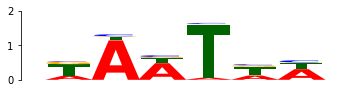

In [457]:
plot_logo(create_logos(find_pfm_on_batch(x_pos,
                                         create_first_layer_model(model, 2, 6),
                                         threshold=0.7)[0])[0])